In [1]:
import numpy as np
from astropy.io import fits as fits
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
from astropy.coordinates import Angle, SkyCoord
from astropy.coordinates import match_coordinates_sky, search_around_sky, match_coordinates_3d
from astropy import units as u
import matplotlib.cm as cm
from astropy.nddata import Cutout2D
import astropy.visualization as viz
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
import astropy.coordinates as coords
from astropy.visualization.wcsaxes import WCSAxes
import astropy.visualization.wcsaxes.frame as frame
from astropy.table import Table
import pandas as pd
import scipy.stats as st
from scipy.stats import kde, sigmaclip
import time
import pickle
import os
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, Normalizer
from IPython.display import Image
import seaborn as sns

%matplotlib notebook
%matplotlib inline

#### Getting both catalogs

In [3]:
Chandra_Data = Table.read('Chandra_COSMOS_Legacy_20151120_4d.fits', format='fits').to_pandas()
HSC_Data = pd.read_csv("/Users/linaflorez/Downloads/156674.csv.gz", dtype = np.float64).dropna(axis = 0, how = "any")

#### Making a pickle from the HSC data release 2 Ultra Deep catalog

In [4]:
# HSC_catalog = SkyCoord(ra = HSC_Data.ra.values * u.degree, dec = HSC_Data.dec.values * u.degree)
# with open('pdr2_ud_skycoords.pkl', 'wb') as f:
#     pickle.dump(HSC_catalog, f)

#### Accessing the pickles

In [5]:
#pickles contain the ra & dec in a more manageable way!
with open('/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Analysis/pdr2_ud_skycoords.pkl', 'rb') as f:
    HSC_catalog = pickle.load(f)
with open('/Users/linaflorez/Desktop/ObsCos/COSMOS_research/venv/Chandra_skycoords.pkl', 'rb') as f:
    Chandra_catalog = pickle.load(f)

#### Applying the match_coordinates_sky function -- aka crossmatching

In [6]:
#idx and sep2d are the length of the Chandra catalog and index the HSC catalog
idx, separation_angles, dist3d = match_coordinates_sky(Chandra_catalog, HSC_catalog, nthneighbor = 1)

#### Making a dataframe with all of the matches sources

In [7]:
# Combining both arrays
result_df = pd.concat([Chandra_Data.reset_index(), HSC_Data.iloc[idx].reset_index()], axis = 1)
result_df.rename(columns={"RA_x": "Chandra_ra", "DEC_x": "Chandra_dec", "ra":"HSC_ra", "dec":"HEC_dec"},inplace = True)

# Maximum separation between sources
max_sep = 2.5 * u.arcsec

# A counterpart is determined based on the separation angle from it's match_coordinates_sky output
no_matches_df = result_df[separation_angles > max_sep]
matches_df = result_df[separation_angles < max_sep]

print("Size of HSC Catalog:", len(HSC_Data))
print("Number of Matches:", len(matches_df))
print("Number of sources without a counterpart:", len(no_matches_df))

Size of HSC Catalog: 7443897
Number of Matches: 3705
Number of sources without a counterpart: 311


#### Making a scatterplot

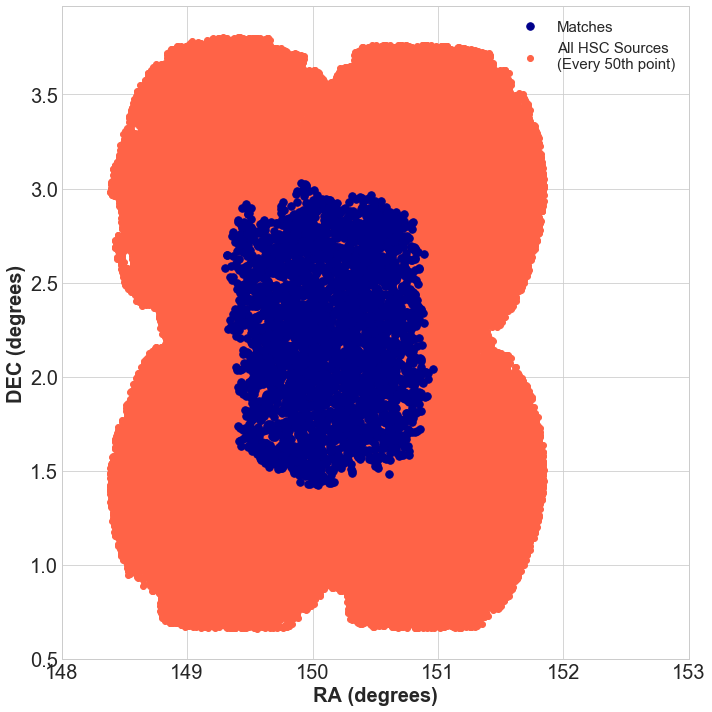

In [8]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize = (10,10))
plt.scatter(HSC_Data.ra[::50], HSC_Data.dec[::50], color = "tomato", label = "All HSC Sources \n(Every 50th point)")
plt.plot(matches_df.Chandra_ra, matches_df.Chandra_dec, ".", color = "darkblue", markersize = 15,label = "Matches")
plt.xlim(148, 153)
plt.xlabel("RA (degrees)", weight = "bold", size = 20)
plt.ylabel("DEC (degrees)", weight = "bold", size = 20)
plt.legend(loc = "best", prop = {"size":15})
plt.tick_params("both", labelsize = 20)
plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/HSC_v_matches.png", transparent = True, dpi = 300)

### Let's look at sources without counterparts

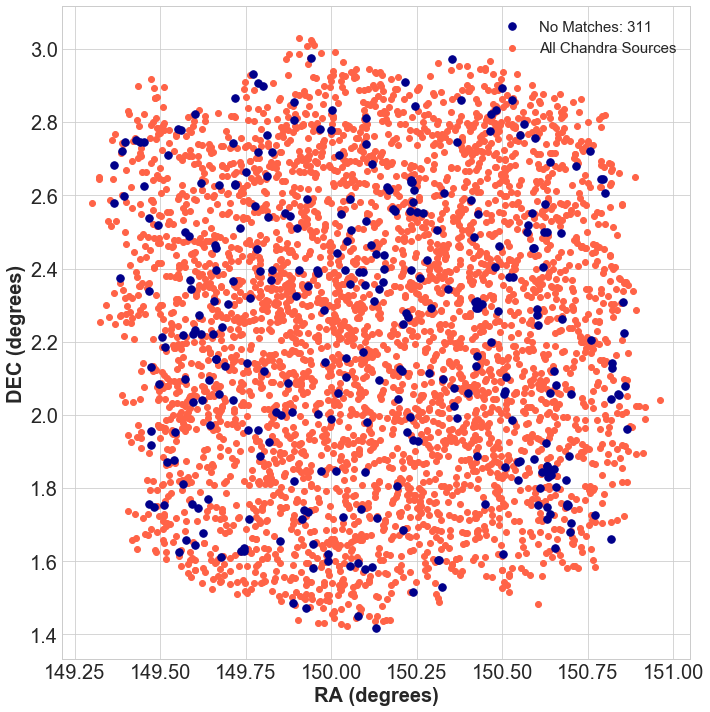

In [9]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize = (10,10))
plt.scatter(Chandra_Data.RA_x, Chandra_Data.DEC_x, color = "tomato", label = "All Chandra Sources")
plt.plot(no_matches_df.Chandra_ra, no_matches_df.Chandra_dec, ".", color = "darkblue", markersize = 15,label = "No Matches: %i" % (len(no_matches_df)))
plt.xlabel("RA (degrees)", weight = "bold", size = 20)
plt.ylabel("DEC (degrees)", weight = "bold", size = 20)
plt.legend(loc = "best", prop = {"size":15})
plt.tick_params("both", labelsize = 20)
plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/match_v_nomatch.png", transparent = True)

In [10]:
no_matches_df.rename(columns={"Chandra_ra":"ra", "Chandra_dec": "dec"},inplace = True)
no_matches_df[["ra","dec"]].to_csv("ud_nomatch_hscmap_input.csv")
no_matches_df.rename(columns={"ra":"Chandra_ra", "dec":"Chandra_dec"},inplace = True)
no_matches_df.reset_index(drop=True, inplace=True)
no_matches_df.drop(columns='index')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


id_x  Chandra_ra  Chandra_dec  pos_err    DET_ML_F    rate_F  \
0    b'cid_1004 '  149.671175     2.057623    0.259   91.089996  0.000312   
1    b'cid_10552'  149.792453     1.887095    0.429  -99.900002  0.000106   
2    b'cid_1056 '  149.754030     2.141884    0.293  190.880005  0.000555   
3    b'cid_1058 '  149.688807     2.133700    0.312   53.119999  0.000317   
4    b'cid_1073 '  149.872720     2.087136    0.402   33.930000  0.000147   
..            ...         ...          ...      ...         ...       ...   
306  b'lid_774  '  149.452440     2.746404    0.248   37.560001  0.000217   
307  b'lid_788  '  149.561537     2.778144    0.505   31.350000  0.000326   
308  b'lid_796  '  149.393835     2.598871    0.598   13.760000  0.000181   
309  b'lid_947  '  149.472253     1.918888    0.443  251.850006  0.001980   
310  b'lid_948  '  149.473249     1.957052    0.660   28.870001  0.000288   

     rate_F_err        flux_F    flux_F_err  snr_F  ...  g_psfflux_mag  \
0      0.000036  5.200000e-15  6.050000e-16   8.58  ...      24.995256   
1    -99.900002  1.740000e-15 -9.990000e+01   0.00  ...      21.997810   
2      0.000062  8.710000e-15  9.800000e-16   8.89  ...      25.419304   
3      0.000052  5.240000e-15  8.600000e-16   6.10  ...      25.411310   
4      0.000038  2.310000e-15  6.030000e-16   3.83  ...      26.151449   
..          ...           ...           ...    ...  ...            ...   
306    0.000048  3.710000e-15  8.120000e-16   4.56  ...      26.916944   
307    0.000067  5.570000e-15  1.150000e-15   4.84  ...      26.393557   
308    0.000065  3.100000e-15  1.110000e-15   2.79  ...      27.362669   
309    0.000194  3.390000e-14  3.320000e-15  10.17  ...      23.863186   
310    0.000063  4.920000e-15  1.080000e-15   4.54  ...      25.319000   

     g_psfflux_magsigma  r_psfflux_mag  r_psfflux_magsigma  i_psfflux_mag  \
0              0.012197      24.102417            0.005868      23.318766   
1              0.000849      21.713448            0.000701      21.612255   
2              0.015664      25.362442            0.016599      25.014933   
3              0.015781      23.671875            0.003680      22.402523   
4              0.031981      25.961250            0.029269      24.829109   
..                  ...            ...                 ...            ...   
306            0.095288      26.393024            0.075551      26.537100   
307            0.059447      26.276289            0.062004      26.222059   
308            0.135305      27.272720            0.140996      27.682783   
309            0.004636      23.260727            0.002976      22.566603   
310            0.017049      24.995272            0.013264      24.677875   

     i_psfflux_magsigma  z_psfflux_mag  z_psfflux_magsigma  y_psfflux_mag  \
0              0.003104      22.977127            0.003398      22.921375   
1              0.000653      21.581524            0.000975      21.584372   
2              0.013703      24.622803            0.014735      24.554111   
3              0.001265      21.669161            0.001053      21.403690   
4              0.011597      23.649260            0.006257      23.331459   
..                  ...            ...                 ...            ...   
306            0.092310      25.868399            0.076499      26.099781   
307            0.061010      25.365959            0.039355      25.624111   
308            0.236351      27.237492            0.237157      28.726330   
309            0.001790      22.380239            0.002318      22.184359   
310            0.011858      24.697876            0.018274      23.990313   

     y_psfflux_magsigma  
0              0.007365  
1              0.002055  
2              0.033741  
3              0.001787  
4              0.010484  
..                  ...  
306            0.240819  
307            0.124315  
308            2.352123  
309            0.004306  
310            0.021761  

[311 rows x 57 columns]

#### Taking hscmap output and prepping the files for my stacking function

In [11]:
matches_df.columns
matches_df.rename(columns={"Chandra_ra":"ra", "Chandra_dec": "dec"},inplace = True)
gcmodel_mag24ish = matches_df.loc[abs(24 - matches_df["g_cmodel_mag"]) < 0.05][['ra','dec']][10:20]
gcmodel_mag24ish.shape
gcmodel_mag24ish.to_csv("gcmodel_mag24ish.csv", index=False) #going to input this into hscmap

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Doing the stacking

In [30]:
def cutout_func(band, result, cut_size): 
    
    dimensions = cut_size * 6
    num = np.zeros((dimensions, dimensions))
    denom = np.zeros((dimensions, dimensions))

    iterating_through_fits_files = np.linspace(0, len(result)-1, len(result), dtype = "int")
    
    if len(iterating_through_fits_files) == 34:
        iterating_through_fits_files = np.delete(iterating_through_fits_files, [2],0)
    
    
    for i in iterating_through_fits_files:
        
        #opening FITS file
        respective_band = result[band].iloc[i]
        hdulist = fits.open(respective_band)
        flux_mag0 = hdulist[0].header["FLUXMAG0"]

        # hscMap output
        image, mask, variance = hdulist[1].data, hdulist[2].data, hdulist[3].data 

        #big general cutout to make sure all stacked images are the same dimensions
        wcs = WCS(hdulist[1].header)
        if "Chandra_ra" in result:
            RA, DEC = result["Chandra_ra"].iloc[i], result["Chandra_dec"].iloc[i]
        else:
            RA, DEC = result["ra"].iloc[i], result["dec"].iloc[i]
            
        coords = SkyCoord(ra=RA*u.degree, dec=DEC*u.degree)
        cut_center, size = SkyCoord(coords), cut_size
        cutout_size = np.array([size, size]) * u.arcsec
        general_cutout = Cutout2D(image, cut_center, cutout_size, wcs=wcs)
        variance_of_cutout = Cutout2D(variance, cut_center, cutout_size, wcs=wcs).data

        #added on/stacked to initialized num/denom arrays
        num += general_cutout.data/variance_of_cutout 
        denom += 1/variance_of_cutout
        

    cutouts = num/denom
    variance_stacked_image = denom**-1
    sky_subtracted =  cutouts - np.median(cutouts)

    #Determining magnitude
    center = (int((6*cut_size)/2)-3, int((6*cut_size)/2)+3)
    original_magnitude = -2.5 * np.log10(np.sum(cutouts[center[0]:center[1], center[0]:center[1]])/flux_mag0)
    sky_subtracted_magnitude = -2.5 * np.log10(np.sum(sky_subtracted[center[0]:center[1], center[0]:center[1]])/flux_mag0)

    #upper limit calculation
    sigma_flux =  np.sum(variance_stacked_image[center[0]:center[1], center[0]:center[1]])**(1/2)
    average_center = np.sum(sky_subtracted[center[0]:center[1], center[0]:center[1]])
    upper_lim = -2.5 * np.log10((average_center + (2*sigma_flux))/flux_mag0)
    ave = -2.5 * np.log10((average_center)/flux_mag0)
    lower_lim = -2.5 * np.log10((average_center - (2*sigma_flux))/flux_mag0)
    
    upper_lim2 = -2.5 * np.log10(((2*sigma_flux))/flux_mag0)
    print("Upper lim: %.3f, Average: %.3f, Lower lim: %.3f, Upperlim2: %.3f" % (upper_lim, ave, lower_lim, upper_lim2))
    

    # Plotting stacked image!
    plt.style.use("dark_background")
    fig,((ax1, ax2,ax3)) = plt.subplots(1,3, figsize = (40,10))
    
    title1 = ('Original Stacking %i %s-band images \n Central 1" region: %.3f mag' % (iterating_through_fits_files.shape[0], band[0], original_magnitude))
    ax1.set_title(title1, weight = "bold", size = 20)
    plot1 = ax1.imshow(cutouts, cmap = "plasma", extent=[-size/2 ,size/2,-size/2 ,size/2], aspect='auto')
    ax1.contour(cutouts, 3, extent=[-size/2 ,size/2,-size/2 ,size/2],cmap='Greys')
    ax1.set_xlabel("Arcsecs", weight = "bold", size = 20)
    ax1.set_ylabel("Arcsecs", weight = "bold", size = 20)
    ax1.tick_params("both", labelsize = 20)
    cbar1 = fig.colorbar(plot1, label = "Flux Units", ax = ax1)
    cbar1.ax.tick_params(labelsize=20, size=15)
    

    title2 = ('Sky Subtracted Stack of %i %s-band images \n Central 1" region: %.3f mag (Upper Limit)' % (iterating_through_fits_files.shape[0], band[0], upper_lim))
    ax2.set_title(title2, weight = "bold", size = 20)
    plot2 = ax2.imshow(sky_subtracted, cmap = "plasma", extent=[-size/2 ,size/2,-size/2 ,size/2], aspect='auto')
    ax2.contour(sky_subtracted, 3, extent=[-size/2, size/2, -size/2, size/2],cmap='Greys')
    ax2.set_xlabel("Arcsecs", weight = "bold", size = 20)
    ax2.set_ylabel("Arcsecs", weight = "bold", size = 20)
    ax2.tick_params("both", labelsize = 20)
    cbar2 = fig.colorbar(plot2, label = "Flux Units", ax = ax2)
    cbar2.ax.tick_params(labelsize=20, size=15)
    
    
    ax3.set_title("Sky subtracted stack", weight = "bold", size = 20)
    ax3.hist(sky_subtracted, bins = np.arange(-.1, .1, 0.002))
    ax3.set_xlim(-0.01, 0.04)
    ax3.set_xlabel("Flux Units", weight = "bold", size = 20)
    ax3.tick_params("both", labelsize = 20)

    plt.tight_layout()
    plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/%s_cutout.png" % (band), transparent = True)

    return 

In [28]:
def stacking_fits_files(folder_path, size):

    fits_dec, g_fits, r_fits, i_fits, z_fits, y_fits= [], [], [], [], [], []
    fits_files_df = pd.DataFrame()

    for subdir, dirs, files in os.walk(folder_path):
        for file in files:
            if file.startswith("cutout-HSC-G"):
                fits_dec.append(float(os.path.join(subdir, file).split(os.sep)[-2]))
                g_fits.append(os.path.join(subdir, file)) 

            if file.startswith("cutout-HSC-R"):
                r_fits.append(os.path.join(subdir, file))

            if file.startswith("cutout-HSC-I"):
                i_fits.append(os.path.join(subdir, file))

            if file.startswith("cutout-HSC-Z"):
                z_fits.append(os.path.join(subdir, file))

            if file.startswith("cutout-HSC-Y"):
                y_fits.append(os.path.join(subdir, file))


    fits_files_df = pd.DataFrame()
    fits_files_df["declination"], fits_files_df["gfits"] = fits_dec, g_fits
    fits_files_df["rfits"], fits_files_df["ifits"], fits_files_df["zfits"], fits_files_df["yfits"] = r_fits, i_fits, z_fits, y_fits


    indices = []
    
    if folder_path == "/Users/linaflorez/Downloads/FITS_FILES/":
        for i in fits_files_df.declination:
            indices.append(no_matches_df[no_matches_df.Chandra_dec == i].index.values[0])
        testing_stacking = pd.concat([no_matches_df.iloc[indices].reset_index(), fits_files_df], axis = 1)

    else:
        for i in fits_files_df.declination:
            indices.append(matches_df[matches_df.dec == i].index.values[0])
        testing_stacking = pd.concat([matches_df.loc[indices].reset_index(), fits_files_df], axis = 1)

    cutout_func("gfits", testing_stacking, size)
    cutout_func("rfits", testing_stacking, size)
    cutout_func("ifits", testing_stacking, size)
    cutout_func("zfits", testing_stacking, size)
    cutout_func("yfits", testing_stacking, size)
    
    
    return testing_stacking

Upper lim: 24.611, Average: 24.614, Lower lim: 24.617, Upperlim2: 30.965
Upper lim: 23.757, Average: 23.759, Lower lim: 23.761, Upperlim2: 30.672
Upper lim: 23.023, Average: 23.025, Lower lim: 23.026, Upperlim2: 30.553
Upper lim: 22.488, Average: 22.489, Lower lim: 22.490, Upperlim2: 29.968
Upper lim: 22.317, Average: 22.319, Lower lim: 22.321, Upperlim2: 29.278


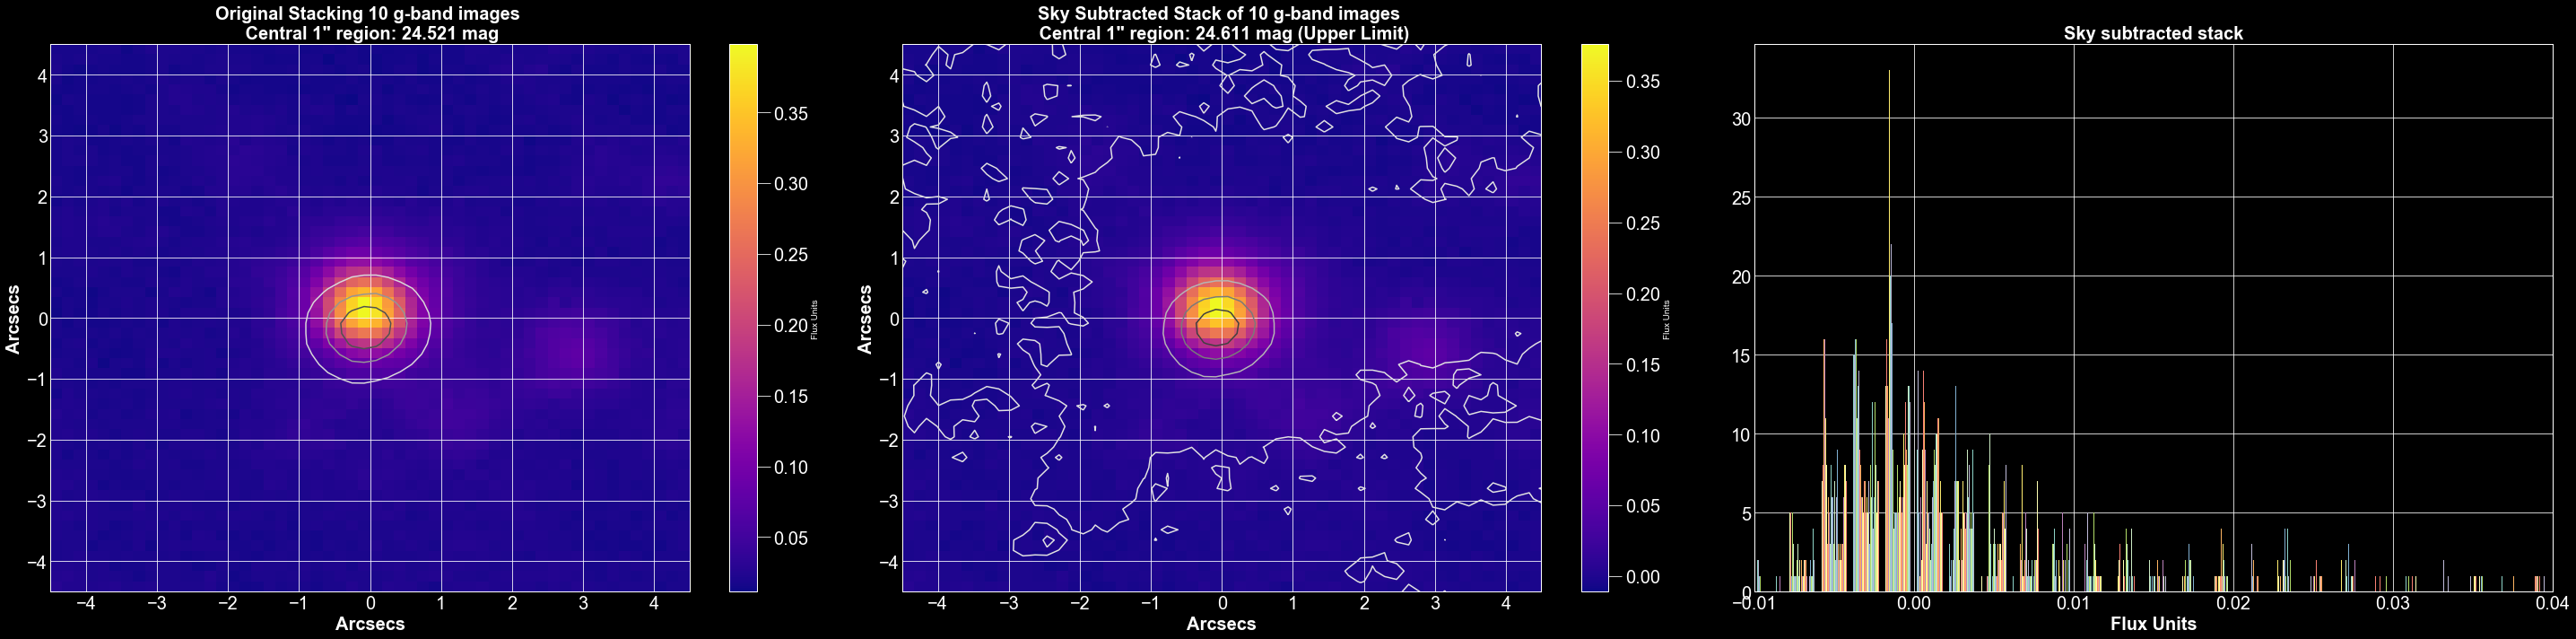

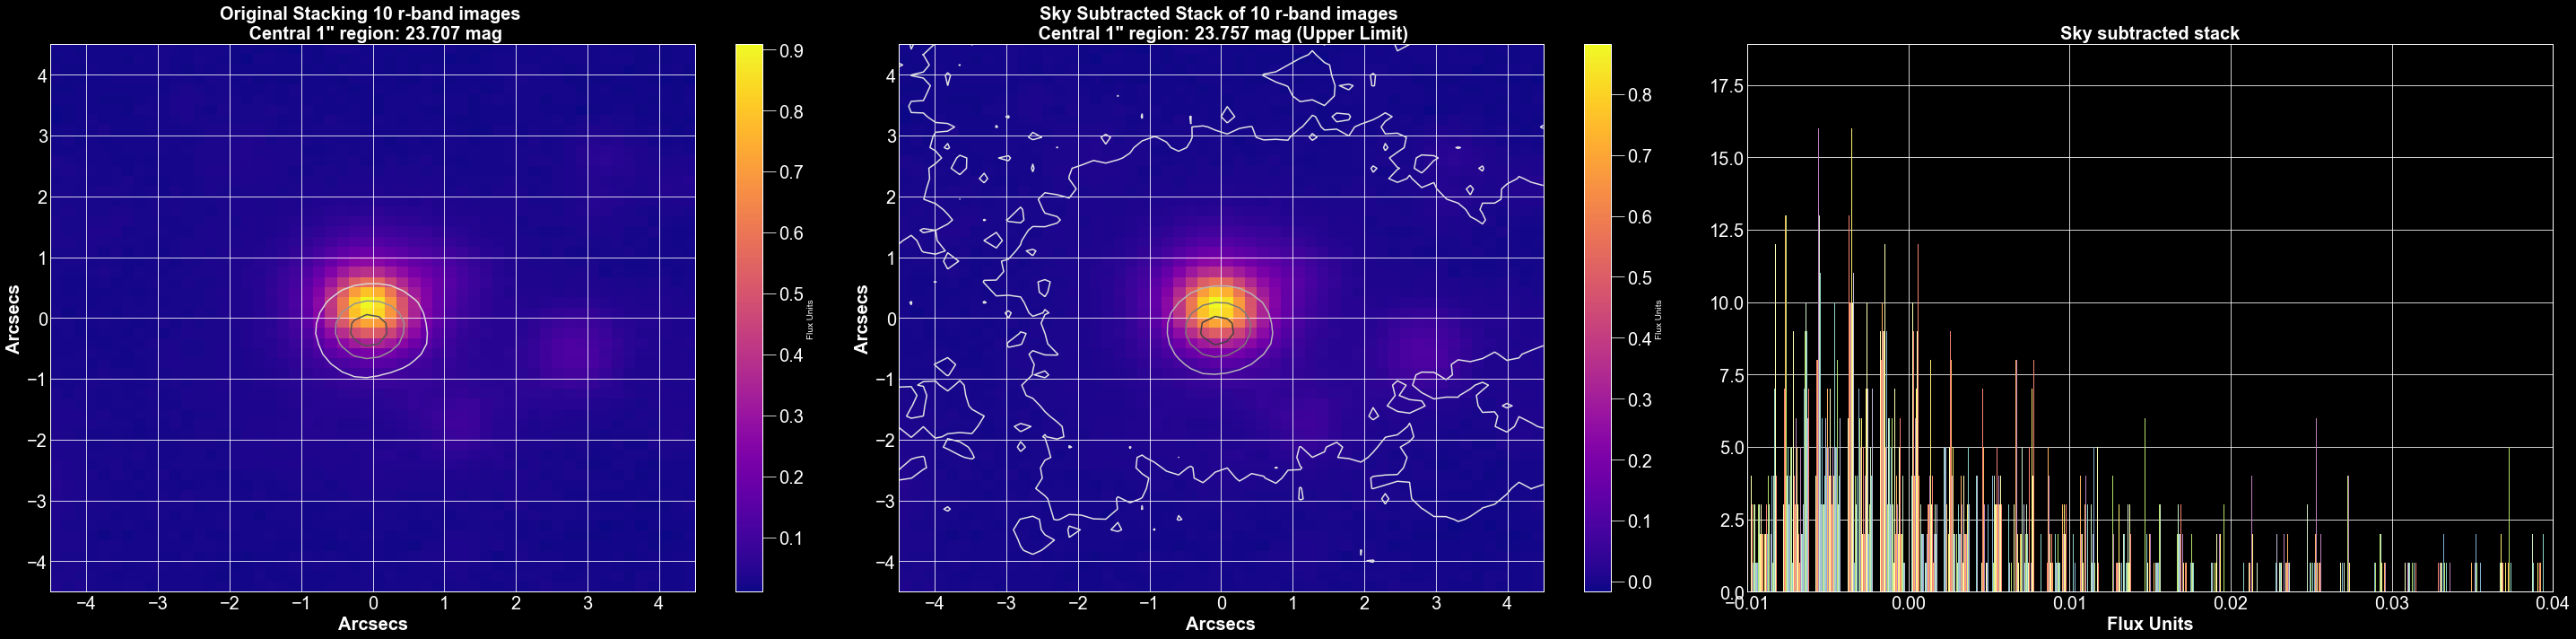

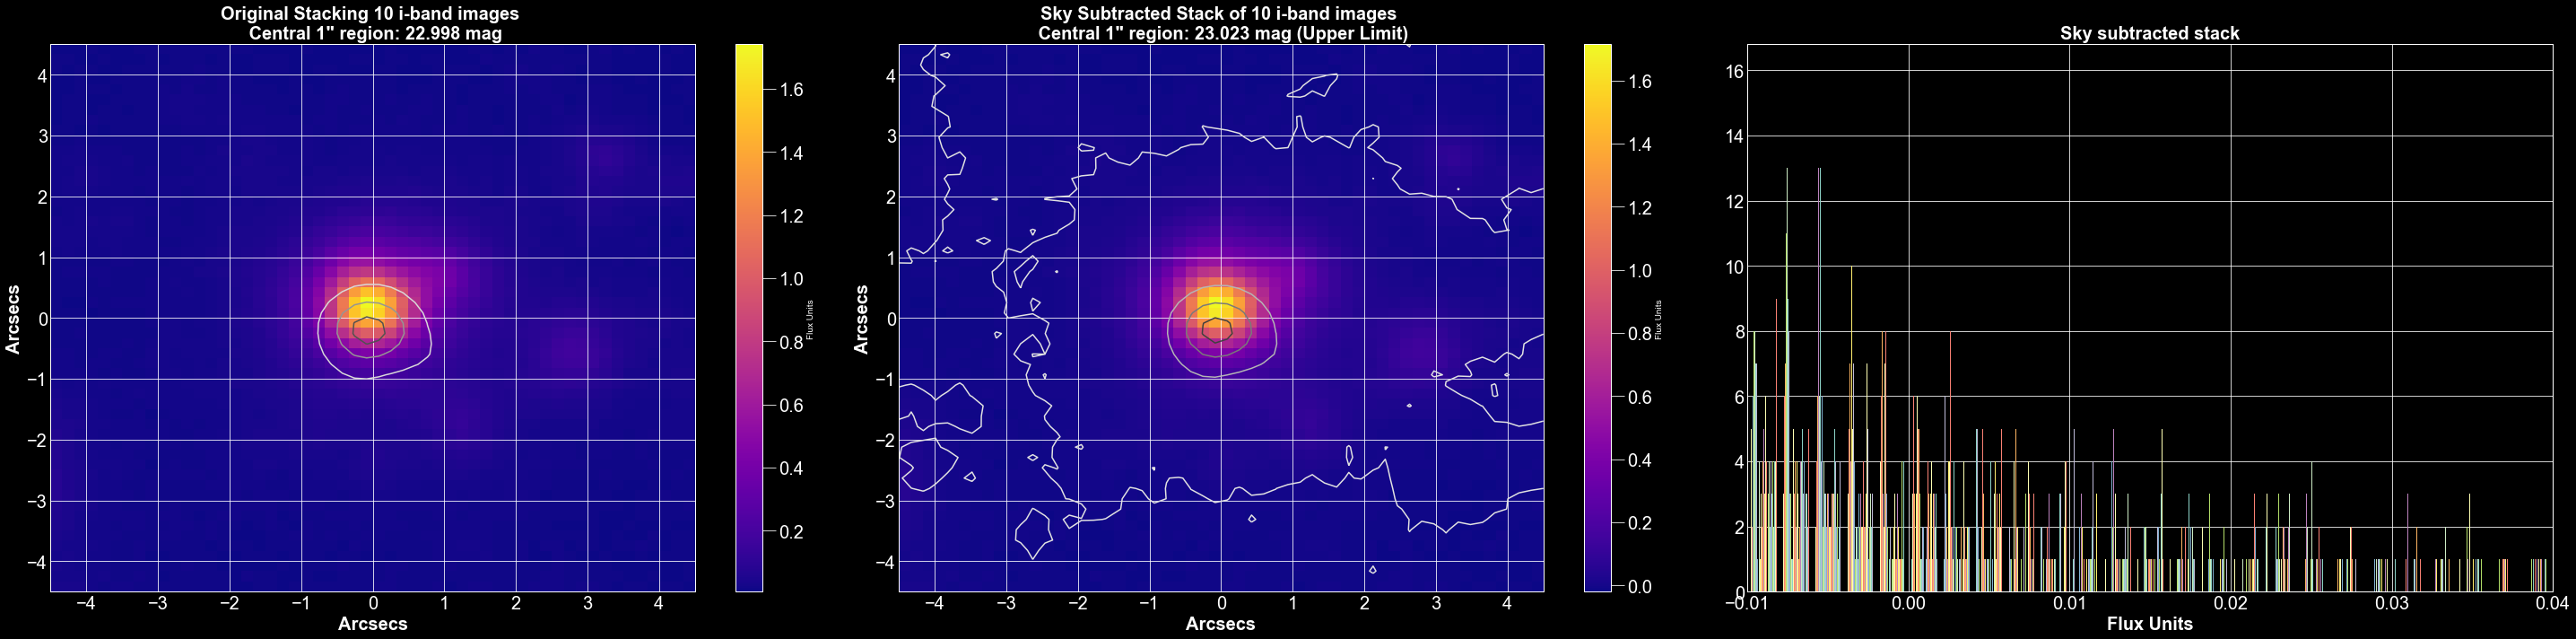

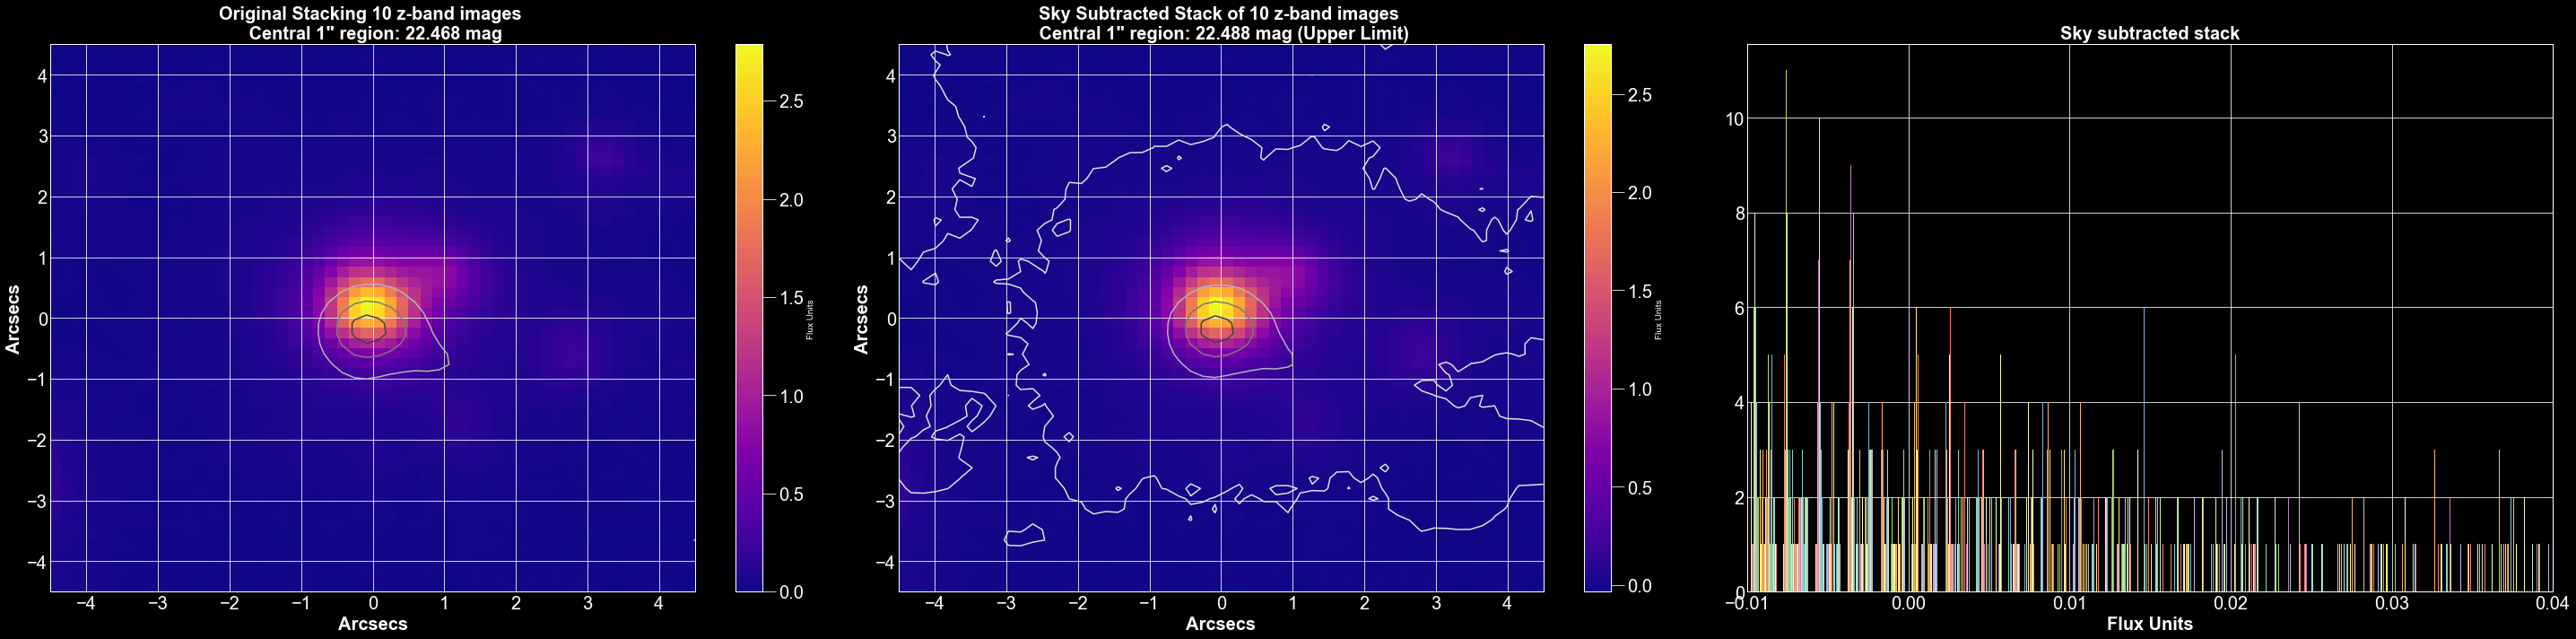

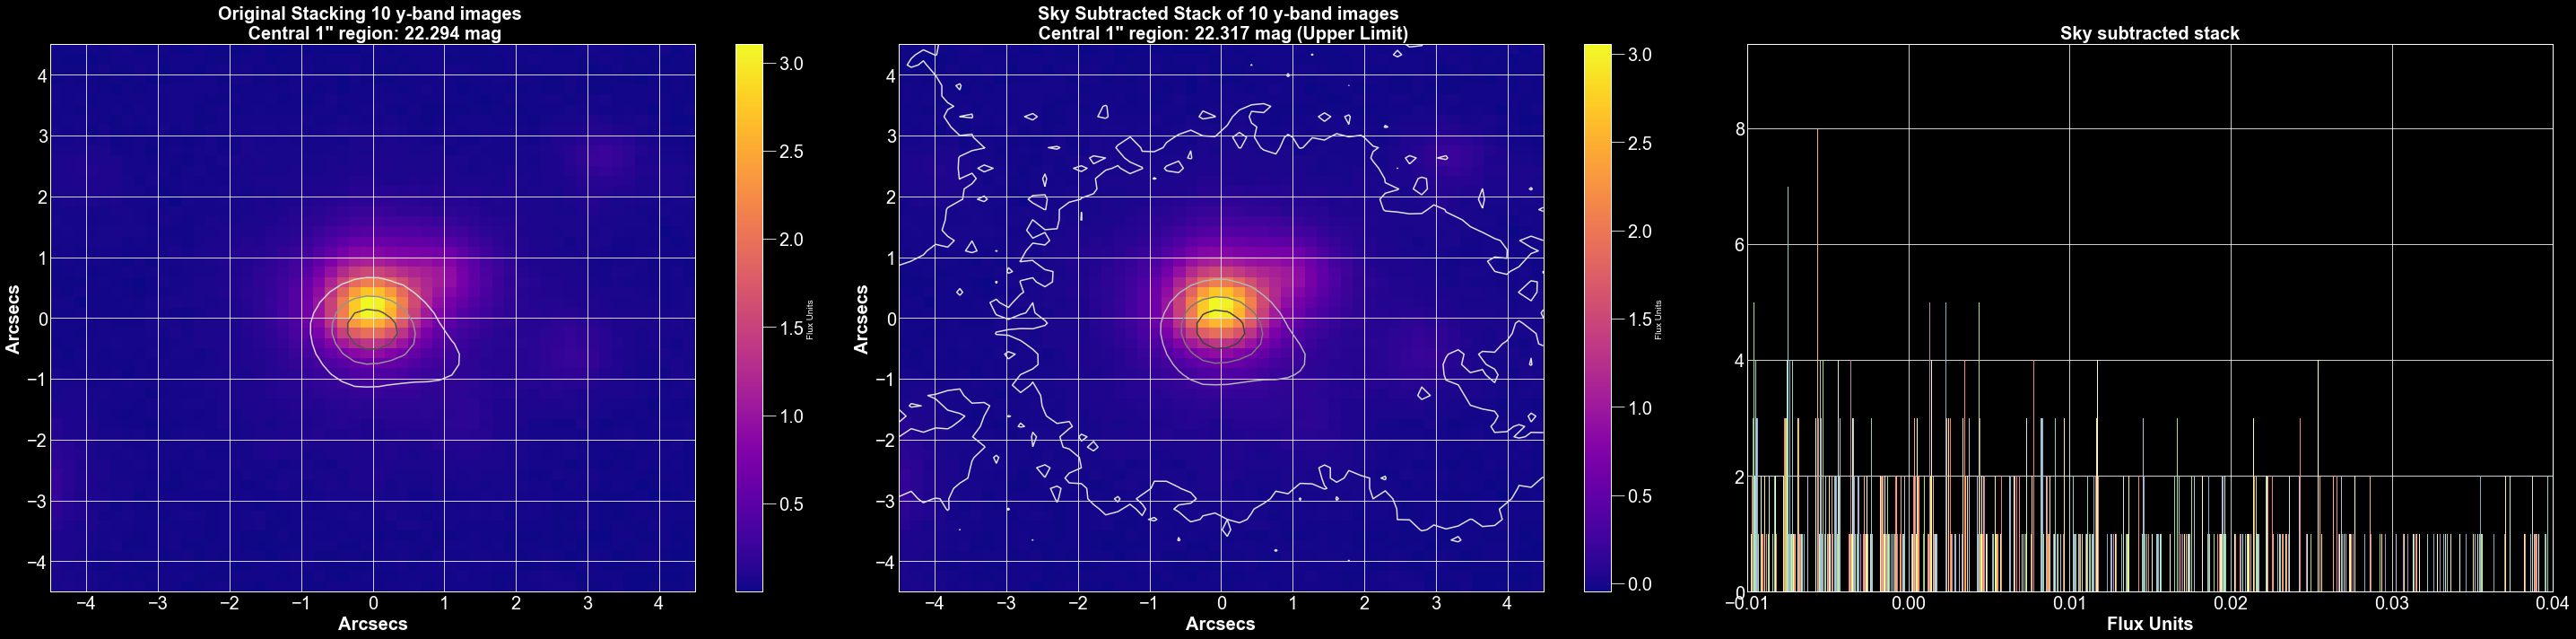

In [14]:
stacking_fits_files("/Users/linaflorez/Downloads/psf24mag_withcounterparts/", 9)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log10


Upper lim: nan, Average: nan, Lower lim: nan, Upperlim2: 31.588


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log10


Upper lim: nan, Average: nan, Lower lim: nan, Upperlim2: 31.297


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log10


Upper lim: nan, Average: nan, Lower lim: nan, Upperlim2: 31.155


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log10


Upper lim: nan, Average: nan, Lower lim: nan, Upperlim2: 30.588


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in log10
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log10


Upper lim: nan, Average: nan, Lower lim: nan, Upperlim2: 29.850


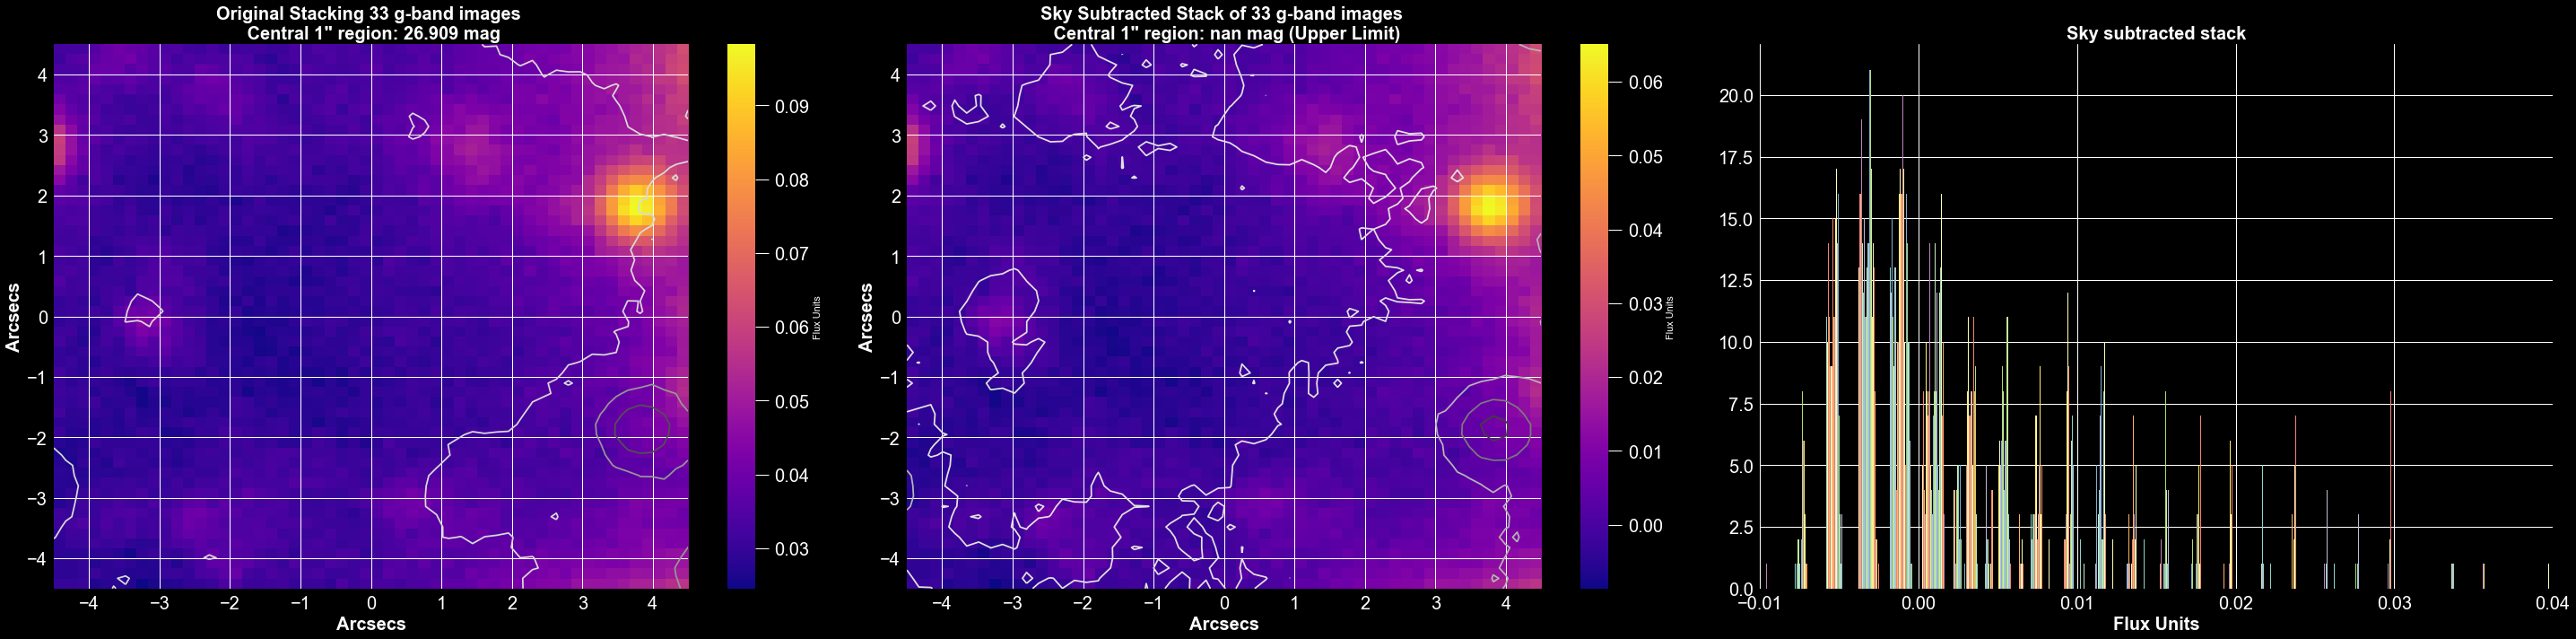

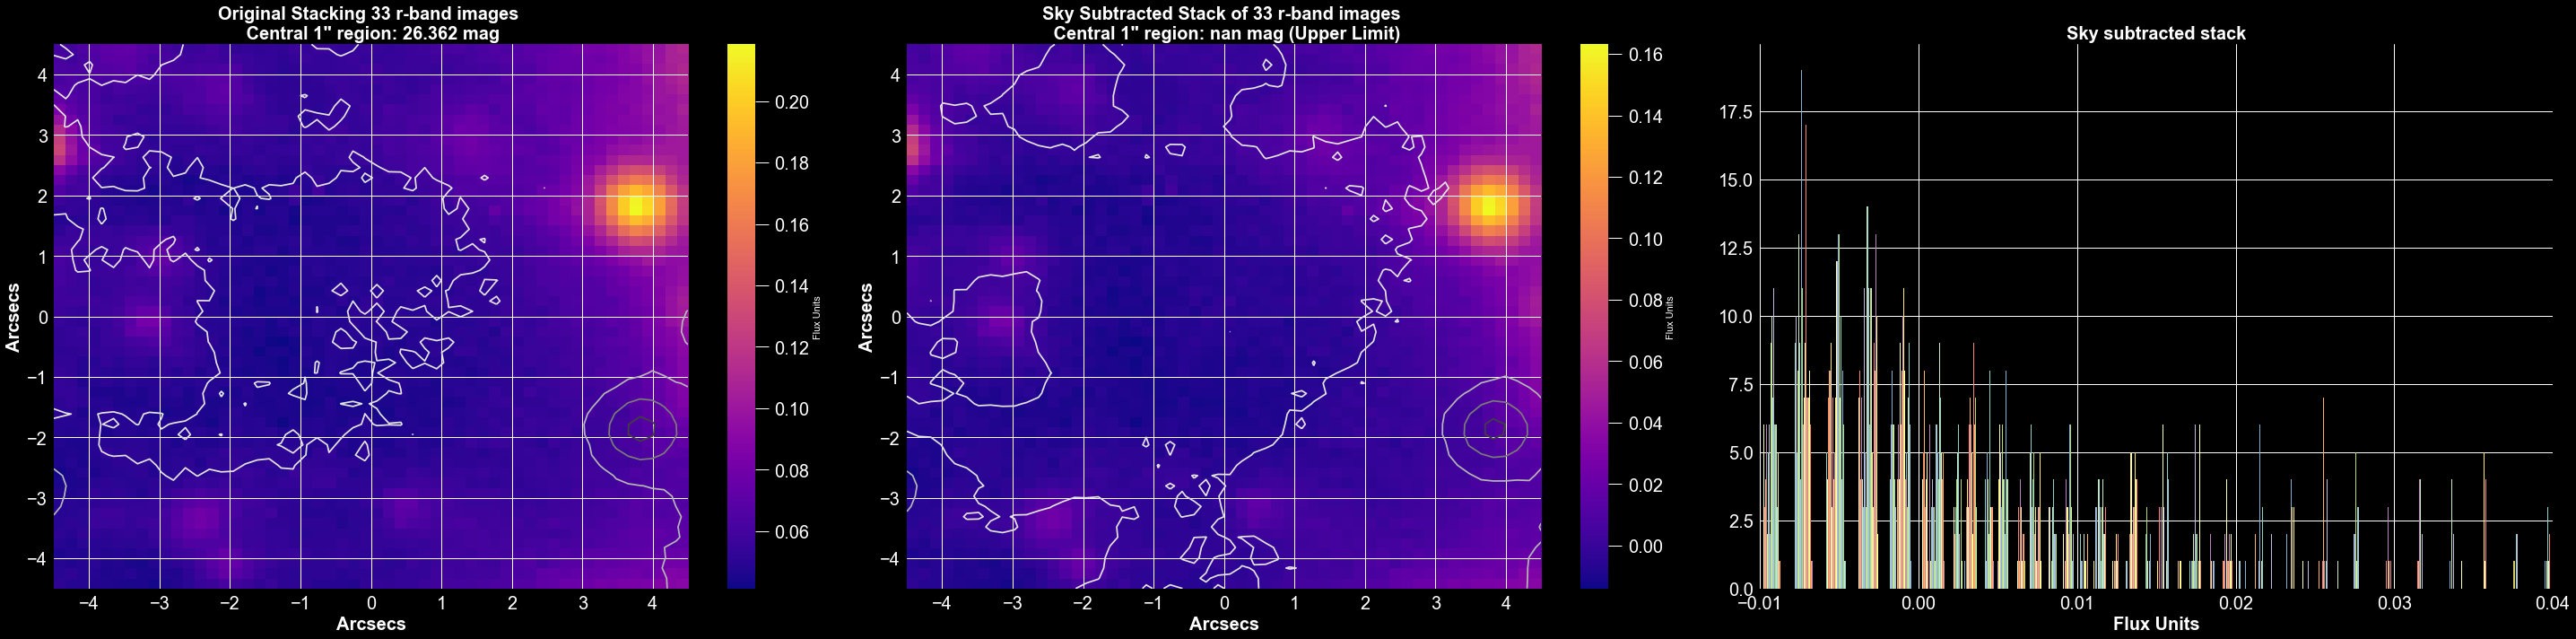

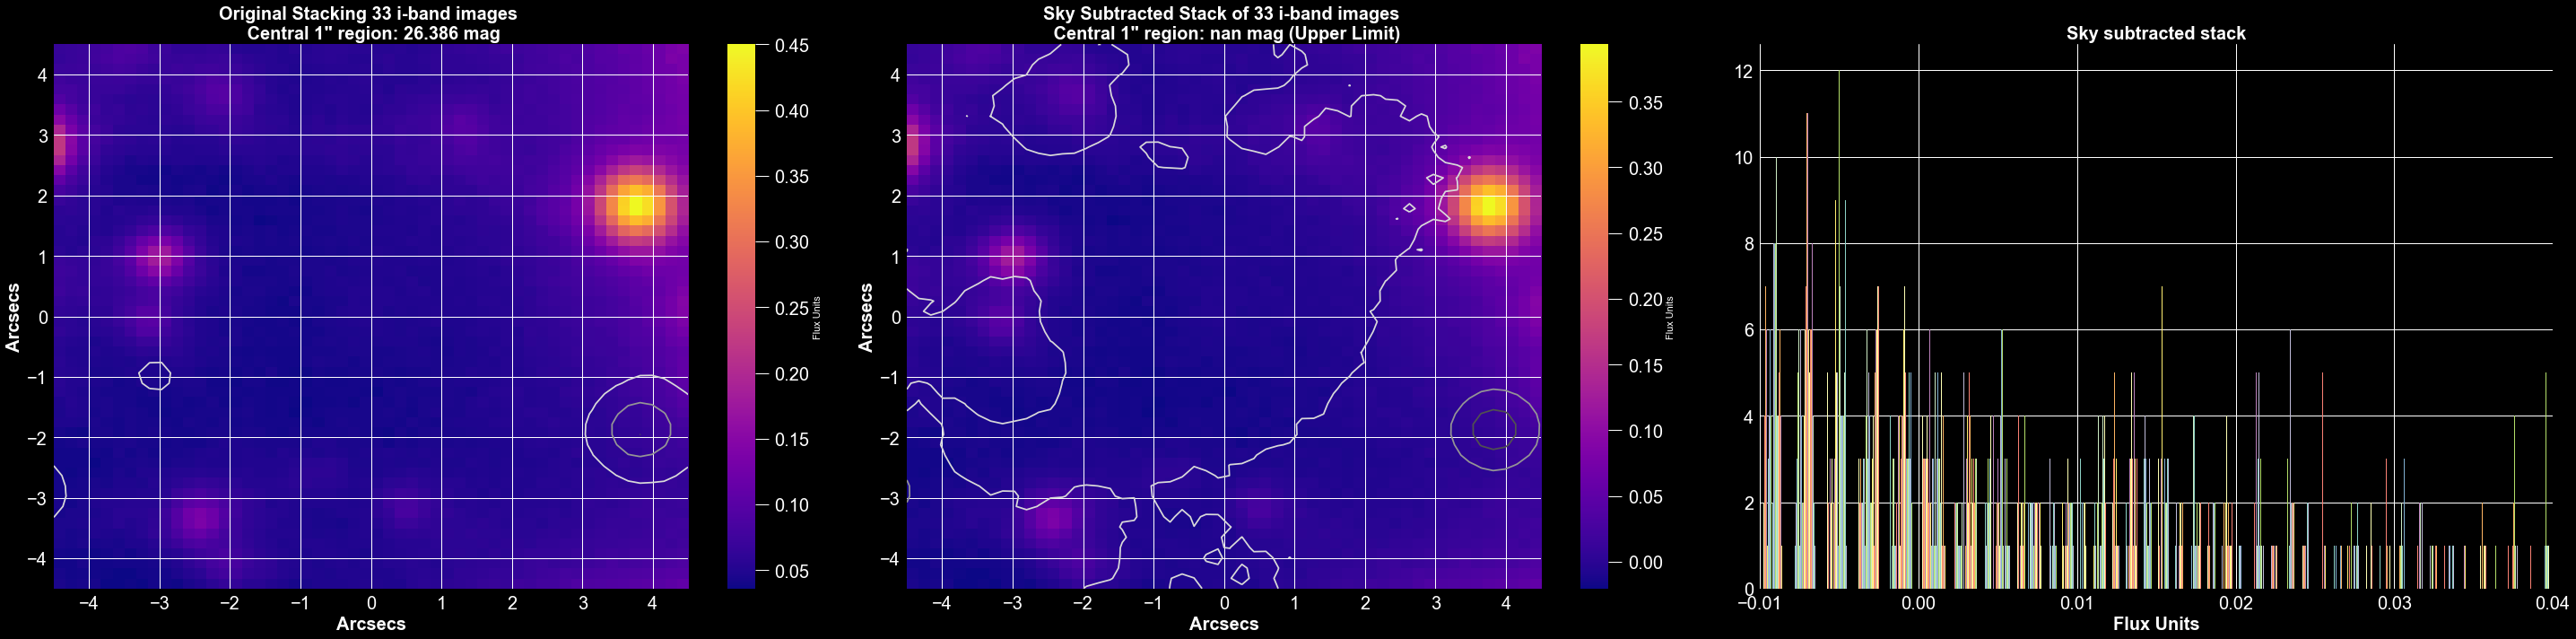

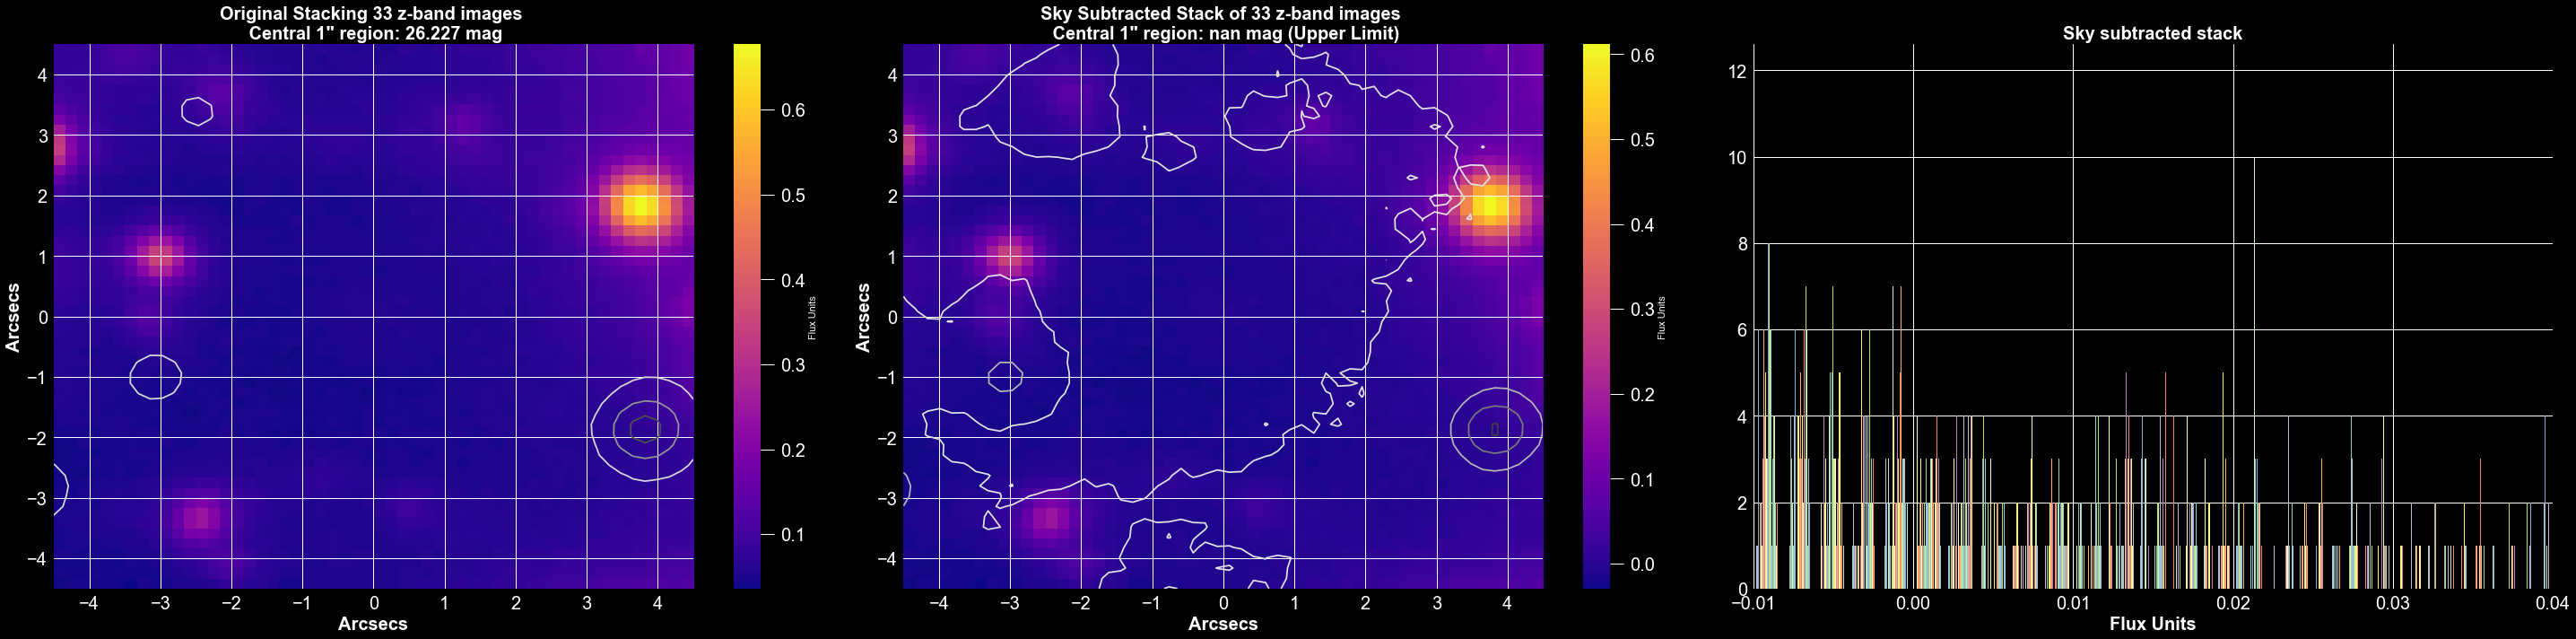

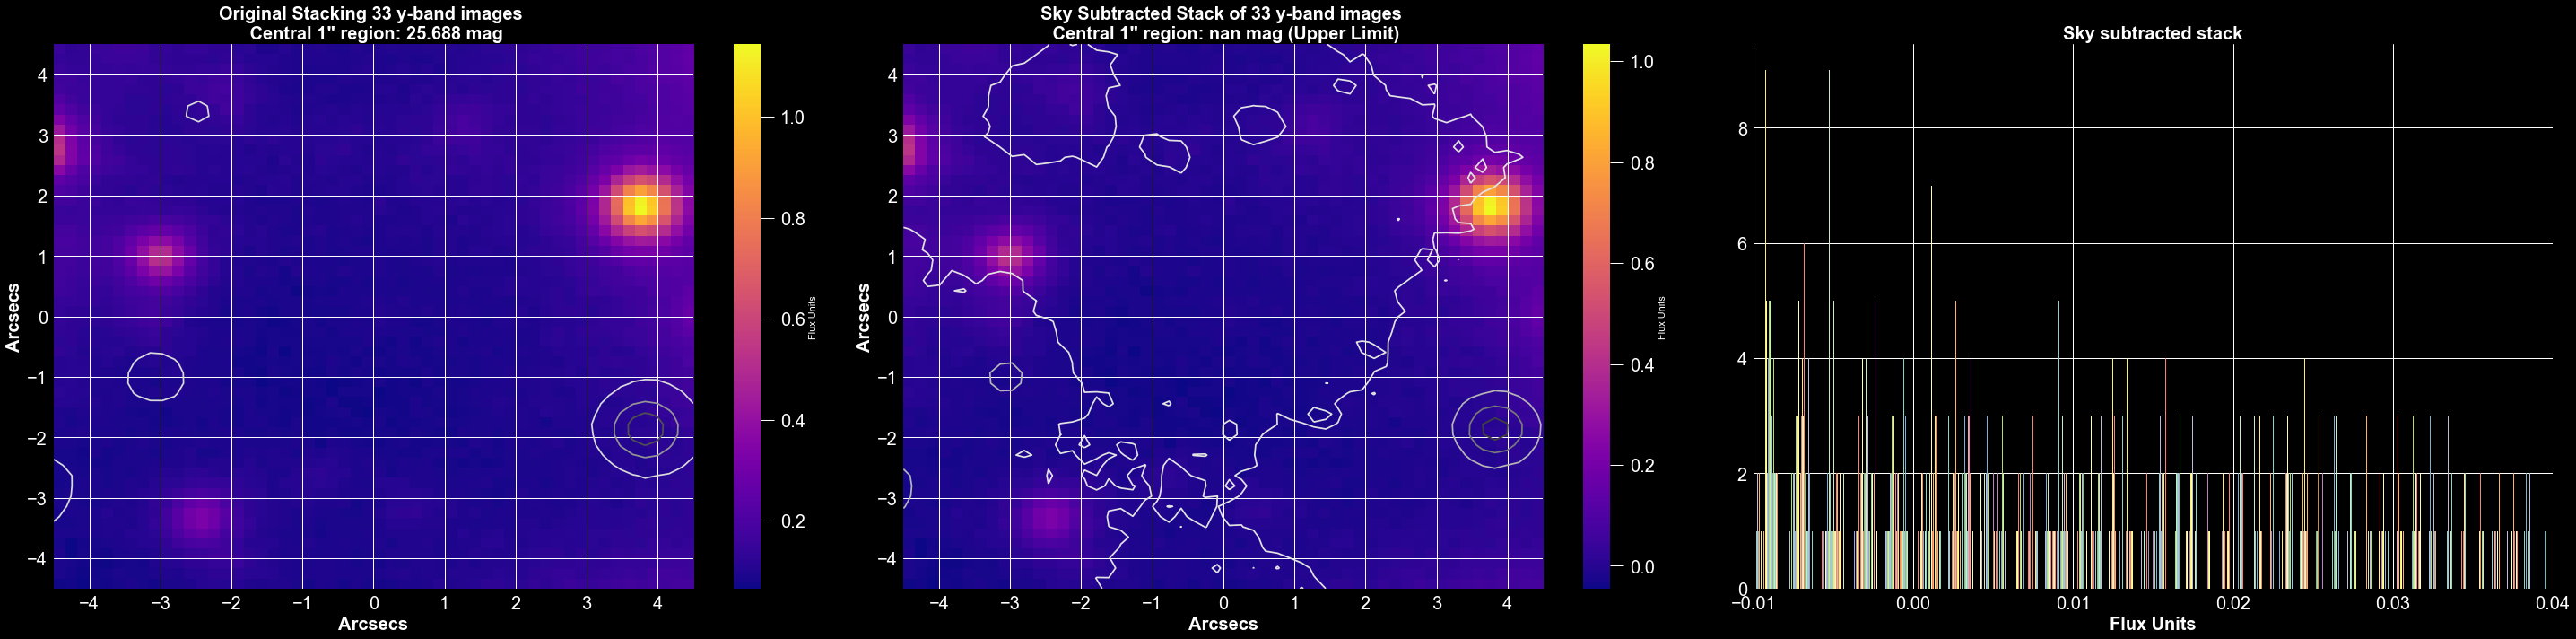

In [43]:
dataframe = stacking_fits_files("/Users/linaflorez/Downloads/FITS_FILES/", 9)

In [44]:
dataframe.rename(columns={"Chandra_ra":"ra", "Chandra_dec": "dec"},inplace = True)
dataframe = dataframe.drop([2])
dataframe[["ra","dec"]].to_csv("sources_wo_counterparts.csv", index=False)
dataframe

level_0  index          id_x          ra       dec  pos_err   DET_ML_F  \
0       242   2977  b'lid_3034 '  150.233274  2.643213    0.781  20.120001   
1       263   3434  b'lid_3870 '  150.639335  1.730072    0.411  27.700001   
3       275   3554  b'lid_425  '  150.378926  2.860019    0.265  54.669998   
4        28    397  b'cid_1466 '  149.817560  1.924838    0.302  40.570000   
5       243   2978  b'lid_3036 '  150.242554  2.614764    0.802  14.410000   
6       261   3411  b'lid_3840 '  150.639775  2.060272    0.499   9.980000   
7        46    654  b'cid_2015 '  150.487040  2.283044    0.946  20.059999   
8       246   3051  b'lid_3148 '  150.214533  2.911189    2.013  12.830000   
9       125   1785  b'lid_1160 '  149.554059  1.626104    0.962  18.010000   
10      276   3596  b'lid_4431 '  149.863224  2.550944    0.611  12.160000   
11      245   3030  b'lid_3115 '  150.100377  2.812555    0.125  12.670000   
12      247   3066  b'lid_3167 '  150.463733  2.775515    0.438  12.020000   
13       24    344  b'cid_1313 '  149.930149  2.590059    0.768  18.370001   
14       16    194  b'cid_11754'  150.209000  2.249554    0.367 -99.000000   
15       56    760  b'cid_2444 '  150.139330  2.343013    2.046  21.650000   
16      291   3756  b'lid_5273 '  149.772160  2.931910    2.565 -99.900002   
17      240   2949  b'lid_2956 '  149.492038  2.517954    1.792   8.520000   
18      274   3525  b'lid_4109 '  150.234443  2.635830    1.384  11.880000   
19      268   3487  b'lid_3952 '  149.582898  2.489419    0.407  28.080000   
20      254   3298  b'lid_3632 '  150.055307  1.586190    0.456  14.260000   
21       14    181  b'cid_11633'  149.897003  2.323927    1.861 -99.000000   
22       20    288  b'cid_1259 '  150.342990  2.344493    0.532  14.450000   
23       54    725  b'cid_2305 '  150.425796  2.160060    0.688  12.600000   
24      308   3977  b'lid_796  '  149.393835  2.598871    0.598  13.760000   
25      234   2908  b'lid_2900 '  150.858383  2.079220    1.459   8.400000   
26       31    460  b'cid_1549 '  149.931550  2.351857    0.429  10.810000   
27       21    293  b'cid_1263 '  150.425190  2.312089    0.744  25.309999   
28      280   3629  b'lid_4601 '  150.034277  1.720897    0.359  12.100000   
29      305   3947  b'lid_766  '  149.387774  2.721355    0.850  30.610001   
30      139   1968  b'lid_1480 '  150.509409  1.857590    0.555  18.639999   
31       49    679  b'cid_2111 '  150.055880  2.357676    0.417   7.300000   
32       29    417  b'cid_1490 '  149.804600  2.118866    0.768  13.900000   
33      128   1791  b'lid_1166 '  149.611117  1.745684    0.538  33.119999   

      rate_F  rate_F_err        flux_F  ...  z_psfflux_mag  \
0   0.000166    0.000040  2.840000e-15  ...      25.996460   
1   0.000122    0.000037  2.090000e-15  ...      25.374157   
3   0.000292    0.000056  4.990000e-15  ...      25.779259   
4   0.000190    0.000046  2.980000e-15  ...      27.366451   
5   0.000142    0.000041  2.430000e-15  ...      28.866856   
6   0.000051    0.000025  8.700000e-16  ...      23.374878   
7   0.000114    0.000040  1.790000e-15  ...      26.857651   
8   0.000211    0.000068  3.610000e-15  ...      24.156105   
9   0.000183    0.000051  3.130000e-15  ...      25.493263   
10  0.000130    0.000039  2.220000e-15  ...      24.706665   
11  0.000272    0.000076  4.650000e-15  ...      26.428095   
12  0.000049    0.000019  8.410000e-16  ...      26.227778   
13  0.000196    0.000041  3.250000e-15  ...      24.329935   
14  0.000592  -99.000000  9.290000e-15  ...      27.026833   
15  0.000088    0.000033  1.380000e-15  ...      25.378124   
16  0.000667  -99.900002  1.140000e-14  ...      25.059626   
17  0.000112    0.000038  1.920000e-15  ...      26.781004   
18  0.000187    0.000047  3.200000e-15  ...      31.991077   
19  0.000129    0.000034  2.210000e-15  ...      26.916674   
20  0.000141    0.000035  2.410000e-15  ...      26.375721   
21  0.000777  -99.000000  1.220000e-14  ...      

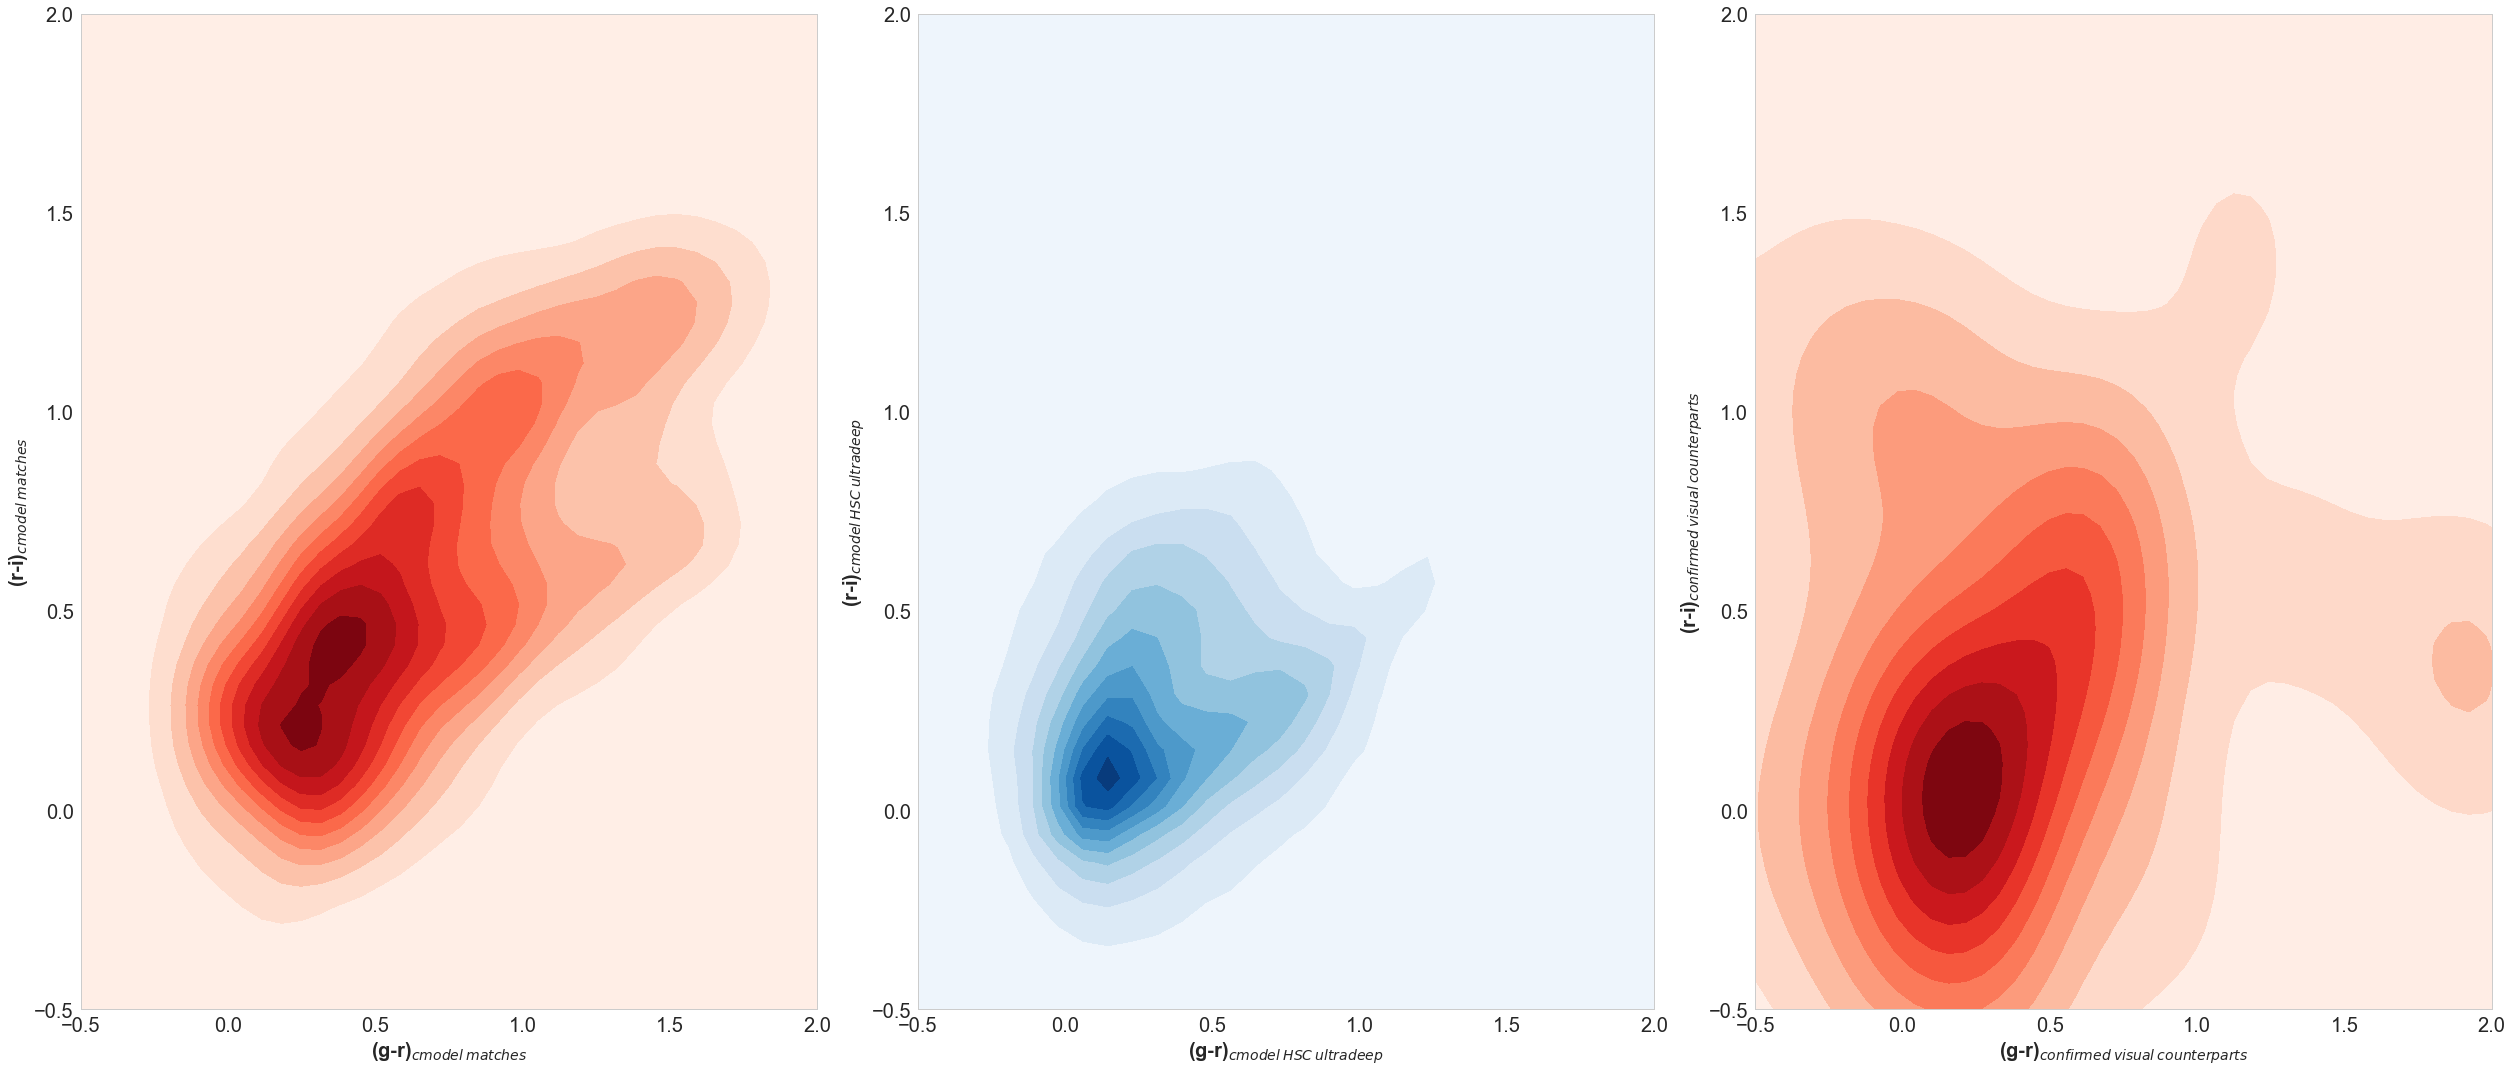

In [268]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (35,15))

min_matches_df = matches_df.loc[(matches_df.g_cmodel_magsigma < 0.2) & (matches_df.r_cmodel_magsigma < 0.2) & (matches_df.i_cmodel_magsigma < 0.2)]
sns.kdeplot(min_matches_df["g_cmodel_mag"] - min_matches_df["r_cmodel_mag"], min_matches_df["r_cmodel_mag"] - min_matches_df["i_cmodel_mag"],\
            cmap='Reds', ax = ax1, shade=True).set(xlim = (-0.5, 2), ylim = (-.5, 2))

min_HSC_Data = HSC_Data.loc[(HSC_Data.g_cmodel_magsigma < 0.2) & (HSC_Data.r_cmodel_magsigma < 0.2) & (HSC_Data.i_cmodel_magsigma < 0.2)]
sns.kdeplot((min_HSC_Data["g_cmodel_mag"] - min_HSC_Data["r_cmodel_mag"])[0::50],(min_HSC_Data["r_cmodel_mag"] - min_HSC_Data["i_cmodel_mag"])[0::50],\
                cmap='Blues' , ax = ax2, shade=True).set(xlim = (-0.5, 2), ylim = (-.5, 2))


visual_counterpart = sns.kdeplot(pd.g_psfflux_mag - pd.r_psfflux_mag, pd.r_psfflux_mag - pd.i_psfflux_mag, cmap='Reds', shade=True, ax = ax3).set(xlim = (-0.5, 2), ylim = (-.5, 2))



ax1.set_xlabel("(g-r)$_{cmodel\:matches}$", weight = "bold", size = 20)
ax1.set_ylabel("(r-i)$_{cmodel\:matches}$", weight = "bold", size = 20)

ax2.set_xlabel("(g-r)$_{cmodel\:HSC\:ultradeep}$", weight = "bold", size = 20)
ax2.set_ylabel("(r-i)$_{cmodel\:HSC\:ultradeep}$", weight = "bold", size = 20)

ax3.set_xlabel("(g-r)$_{confirmed\:visual\:counterparts}$", weight = "bold", size = 20)
ax3.set_ylabel("(r-i)$_{confirmed\:visual\:counterparts}$", weight = "bold", size = 20)

ax1.tick_params("both", labelsize = 20)
ax2.tick_params("both", labelsize = 20)
ax3.tick_params("both", labelsize = 20)

plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/Matches/gr_ri.png", transparent = "True")


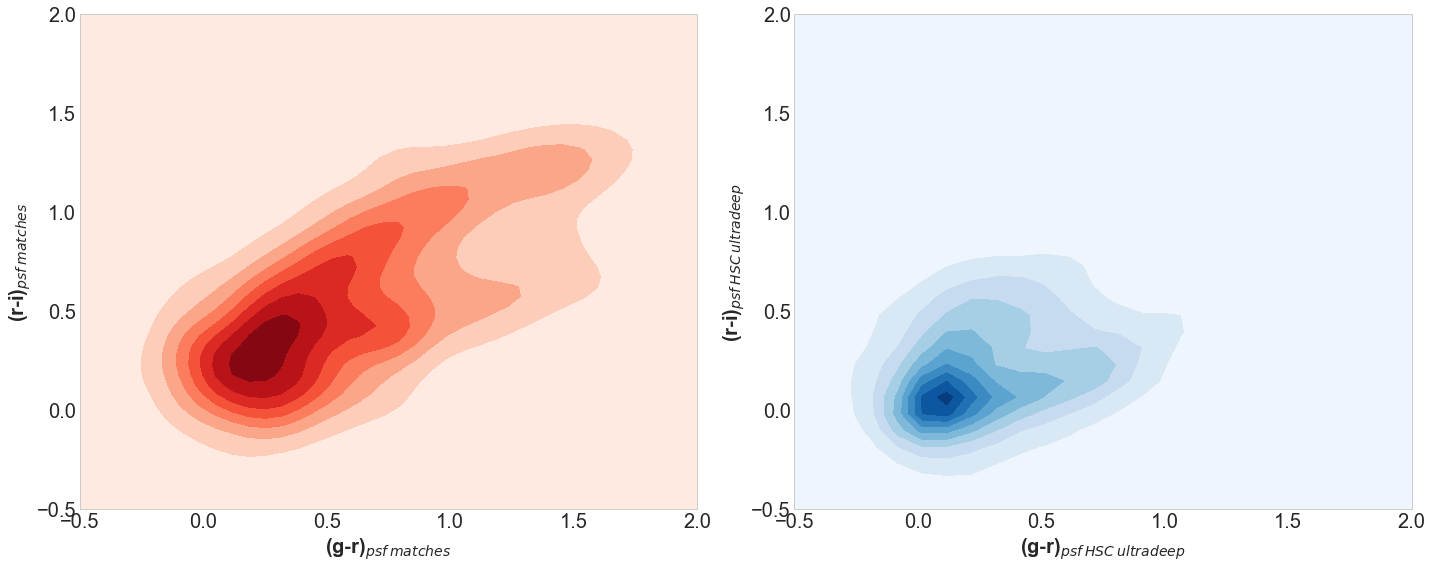

In [19]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,8))
min_matches_df = matches_df.loc[(matches_df.g_psfflux_magsigma < 0.2) & (matches_df.r_psfflux_magsigma < 0.2) & (matches_df.i_psfflux_magsigma < 0.2)]
sns.kdeplot(min_matches_df["g_psfflux_mag"] - min_matches_df["r_psfflux_mag"], min_matches_df["r_psfflux_mag"] - min_matches_df["i_psfflux_mag"],\
            cmap='Reds', ax = ax1, shade=True).set(xlim = (-0.5, 2), ylim = (-.5, 2))

min_HSC_Data = HSC_Data.loc[(HSC_Data.g_psfflux_magsigma < 0.2) & (HSC_Data.r_psfflux_magsigma < 0.2) & (HSC_Data.i_psfflux_magsigma < 0.2)]
sns.kdeplot((min_HSC_Data["g_psfflux_mag"] - min_HSC_Data["r_psfflux_mag"])[0::50],(min_HSC_Data["r_psfflux_mag"] - min_HSC_Data["i_psfflux_mag"])[0::50],\
                cmap='Blues' , ax = ax2, shade=True).set(xlim = (-0.5, 2), ylim = (-.5, 2))
ax1.set_xlabel("(g-r)$_{psf\:matches}$", weight = "bold", size = 20)
ax1.set_ylabel("(r-i)$_{psf\:matches}$", weight = "bold", size = 20)

ax2.set_xlabel("(g-r)$_{psf\:HSC\:ultradeep}$", weight = "bold", size = 20)
ax2.set_ylabel("(r-i)$_{psf\:HSC\:ultradeep}$", weight = "bold", size = 20)

ax1.tick_params("both", labelsize = 20)
ax2.tick_params("both", labelsize = 20)
plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/Matches/gr_ri_psf.png", transparent = "True")

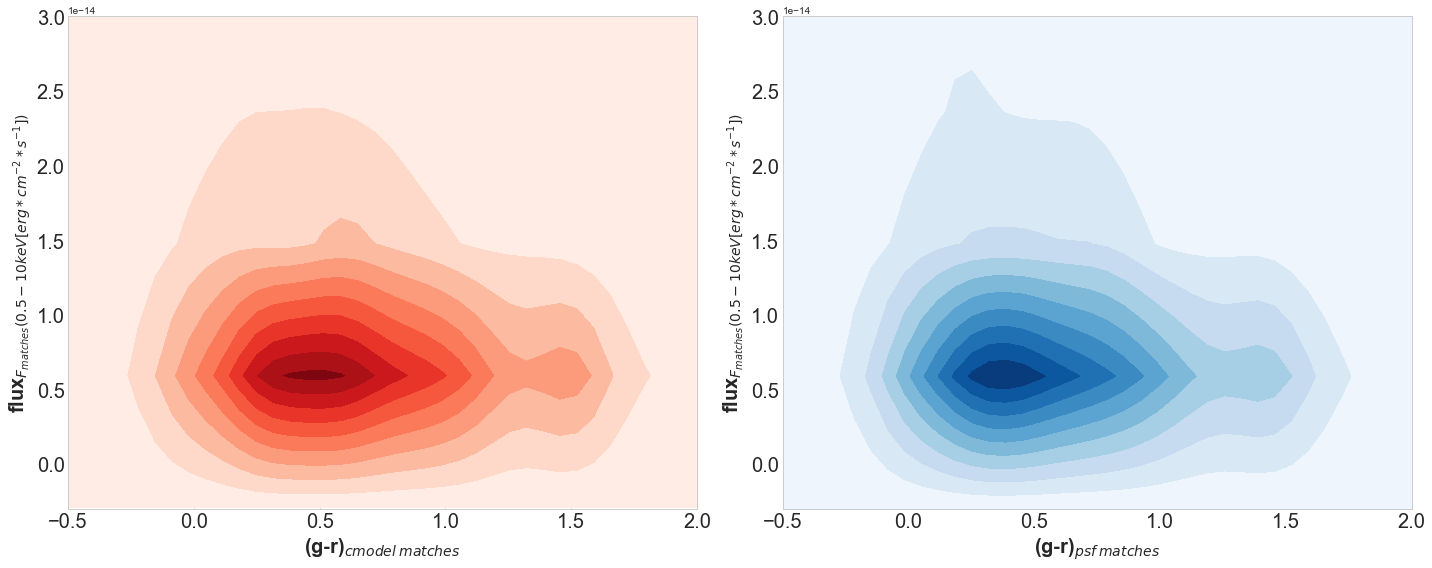

In [20]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,8))

min_matches_df = matches_df.loc[(matches_df.g_cmodel_magsigma < 0.2) & (matches_df.r_cmodel_magsigma < 0.2)]
sns.kdeplot(min_matches_df["g_cmodel_mag"] - min_matches_df["r_cmodel_mag"], min_matches_df["flux_F"],\
            cmap='Reds', ax = ax1, shade=True).set(xlim = (-0.5, 2), ylim = (-3e-15, 3e-14))

min_matches_df = matches_df.loc[(matches_df.g_psfflux_magsigma < 0.2) & (matches_df.r_psfflux_magsigma < 0.2)]
sns.kdeplot((min_matches_df["g_psfflux_mag"] - min_matches_df["r_psfflux_mag"]),min_matches_df["flux_F"],\
                cmap='Blues', ax = ax2, shade=True).set(xlim = (-0.5, 2), ylim = (-3e-15, 3e-14))

ax1.set_xlabel("(g-r)$_{cmodel\:matches}$", weight = "bold", size = 20)
ax1.set_ylabel("flux$_{F_{matches}(0.5 - 10keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax2.set_xlabel("(g-r)$_{psf\:matches}$", weight = "bold", size = 20)
ax2.set_ylabel("flux$_{F_{matches}(0.5 - 10keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax1.tick_params("both", labelsize = 20)
ax2.tick_params("both", labelsize = 20)

plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/gr_fluxF.png", transparent = True)


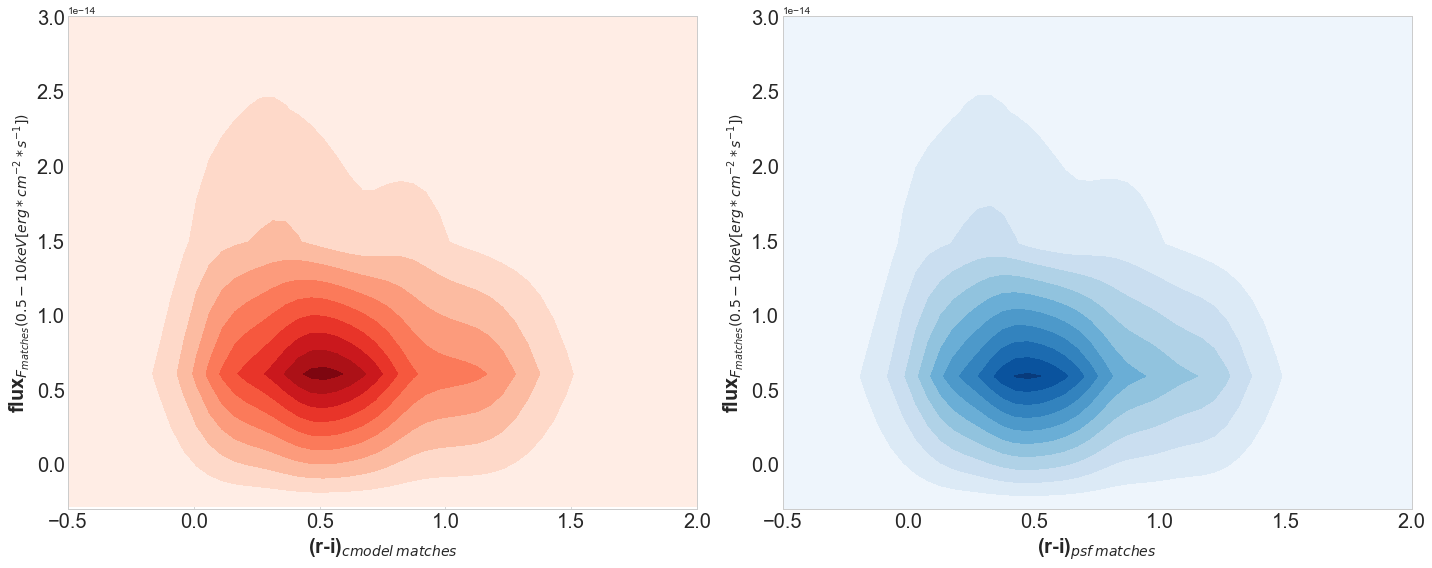

In [21]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,8))

min_matches_df = matches_df.loc[(matches_df.r_cmodel_magsigma < 0.2) & (matches_df.i_cmodel_magsigma < 0.2)]
sns.kdeplot(min_matches_df["r_cmodel_mag"] - min_matches_df["i_cmodel_mag"], min_matches_df["flux_F"],\
            cmap='Reds', ax = ax1, shade=True).set(xlim = (-0.5, 2), ylim = (-3e-15, 3e-14))

min_matches_df = matches_df.loc[(matches_df.g_psfflux_magsigma < 0.2) & (matches_df.r_psfflux_magsigma < 0.2)]
sns.kdeplot((min_matches_df["r_psfflux_mag"] - min_matches_df["i_psfflux_mag"]),min_matches_df["flux_F"],\
                cmap='Blues', ax = ax2, shade=True).set(xlim = (-0.5, 2), ylim = (-3e-15, 3e-14))

ax1.set_xlabel("(r-i)$_{cmodel\:matches}$", weight = "bold", size = 20)
ax1.set_ylabel("flux$_{F_{matches}(0.5 - 10keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax2.set_xlabel("(r-i)$_{psf\:matches}$", weight = "bold", size = 20)
ax2.set_ylabel("flux$_{F_{matches}(0.5 - 10keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax1.tick_params("both", labelsize = 20)
ax2.tick_params("both", labelsize = 20)

plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/ri_fluxF.png", transparent = True)


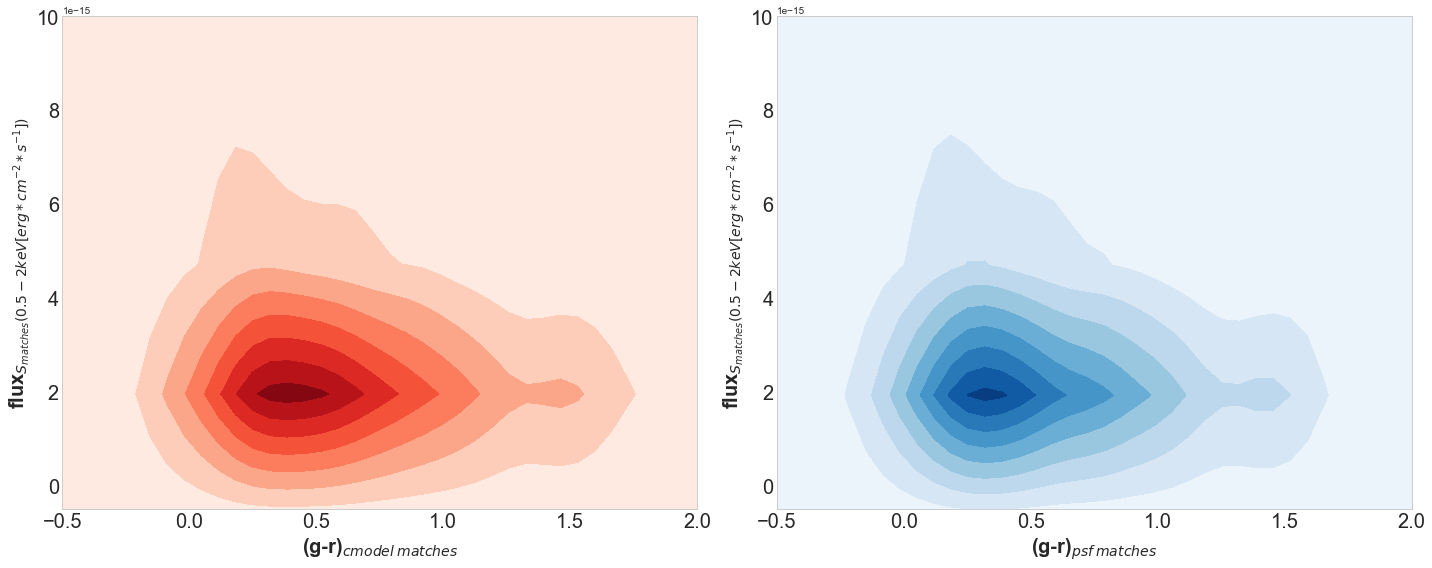

In [22]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,8))

min_matches_df = matches_df.loc[(matches_df.r_cmodel_magsigma < 0.2) & (matches_df.i_cmodel_magsigma < 0.2)]
sns.kdeplot(min_matches_df["g_cmodel_mag"] - min_matches_df["r_cmodel_mag"], min_matches_df["flux_S"],\
            cmap='Reds', ax = ax1, shade=True).set(xlim = (-0.5, 2), ylim = (-5e-16, 1e-14))


min_matches_df = matches_df.loc[(matches_df.g_psfflux_magsigma < 0.2) & (matches_df.r_psfflux_magsigma < 0.2)]
sns.kdeplot((min_matches_df["g_psfflux_mag"] - min_matches_df["r_psfflux_mag"]),min_matches_df["flux_S"],\
                cmap='Blues', ax = ax2, shade=True).set(xlim = (-0.5, 2), ylim = (-5e-16, 1e-14))

ax1.set_xlabel("(g-r)$_{cmodel\:matches}$", weight = "bold", size = 20)
ax1.set_ylabel("flux$_{S_{matches}(0.5 - 2keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax2.set_xlabel("(g-r)$_{psf\:matches}$", weight = "bold", size = 20)
ax2.set_ylabel("flux$_{S_{matches}(0.5 - 2keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax1.tick_params("both", labelsize = 20)
ax2.tick_params("both", labelsize = 20)

plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/gr_fluxS.png", transparent = True)


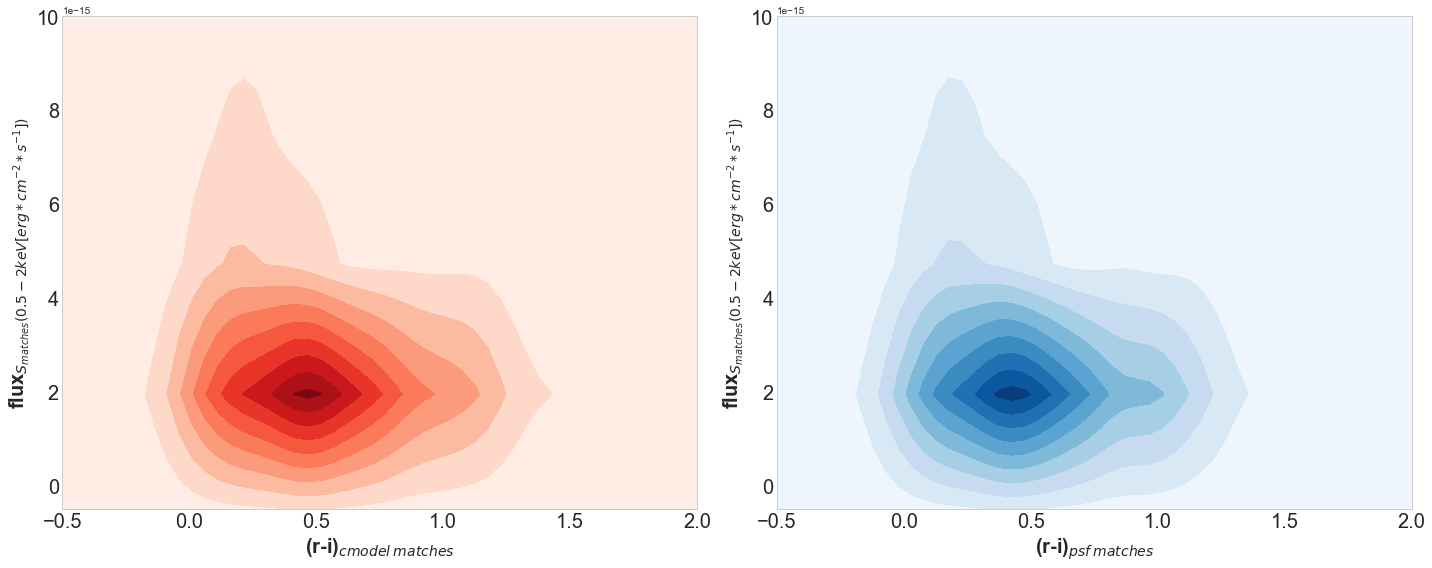

In [23]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,8))

min_matches_df = matches_df.loc[(matches_df.r_cmodel_magsigma < 0.2) & (matches_df.i_cmodel_magsigma < 0.2)]
sns.kdeplot(min_matches_df["r_cmodel_mag"] - min_matches_df["i_cmodel_mag"], min_matches_df["flux_S"],\
            cmap='Reds', ax = ax1, shade=True).set(xlim = (-0.5, 2), ylim = (-5e-16, 1e-14))


min_matches_df = matches_df.loc[(matches_df.r_psfflux_magsigma < 0.2) & (matches_df.i_psfflux_magsigma < 0.2)]
sns.kdeplot((min_matches_df["r_psfflux_mag"] - min_matches_df["i_psfflux_mag"]),min_matches_df["flux_S"],\
                cmap='Blues', ax = ax2, shade=True).set(xlim = (-0.5, 2), ylim = (-5e-16, 1e-14))

ax1.set_xlabel("(r-i)$_{cmodel\:matches}$", weight = "bold", size = 20)
ax1.set_ylabel("flux$_{S_{matches}(0.5 - 2keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax2.set_xlabel("(r-i)$_{psf\:matches}$", weight = "bold", size = 20)
ax2.set_ylabel("flux$_{S_{matches}(0.5 - 2keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax1.tick_params("both", labelsize = 20)
ax2.tick_params("both", labelsize = 20)

plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/ri_fluxS.png", transparent = True)


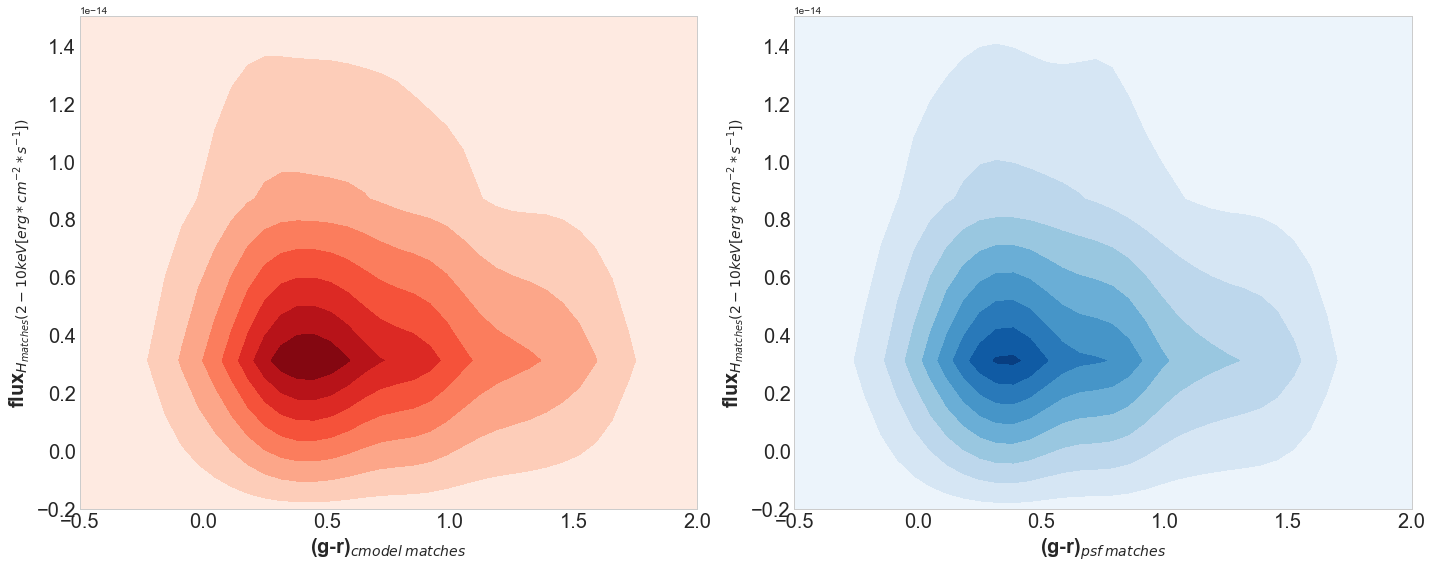

In [24]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,8))
min_matches_df = matches_df.loc[(matches_df.g_cmodel_magsigma < 0.2) & (matches_df.r_cmodel_magsigma < 0.2)]
sns.kdeplot(min_matches_df["g_cmodel_mag"] - min_matches_df["r_cmodel_mag"], min_matches_df["flux_H"],\
            cmap='Reds', ax = ax1, shade=True).set(xlim = (-0.5, 2), ylim = (-2e-15, 1.5e-14))


min_matches_df = matches_df.loc[(matches_df.g_psfflux_magsigma < 0.2) & (matches_df.r_psfflux_magsigma < 0.2)]
sns.kdeplot((min_matches_df["g_psfflux_mag"] - min_matches_df["r_psfflux_mag"]),min_matches_df["flux_H"],\
                cmap='Blues', ax = ax2, shade=True).set(xlim = (-0.5, 2), ylim = (-2e-15, 1.5e-14))

ax1.set_xlabel("(g-r)$_{cmodel\:matches}$", weight = "bold", size = 20)
ax1.set_ylabel("flux$_{H_{matches}(2 - 10keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax2.set_xlabel("(g-r)$_{psf\:matches}$", weight = "bold", size = 20)
ax2.set_ylabel("flux$_{H_{matches}(2 - 10keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax1.tick_params("both", labelsize = 20)
ax2.tick_params("both", labelsize = 20)

plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/gr_fluxH.png", transparent = True)


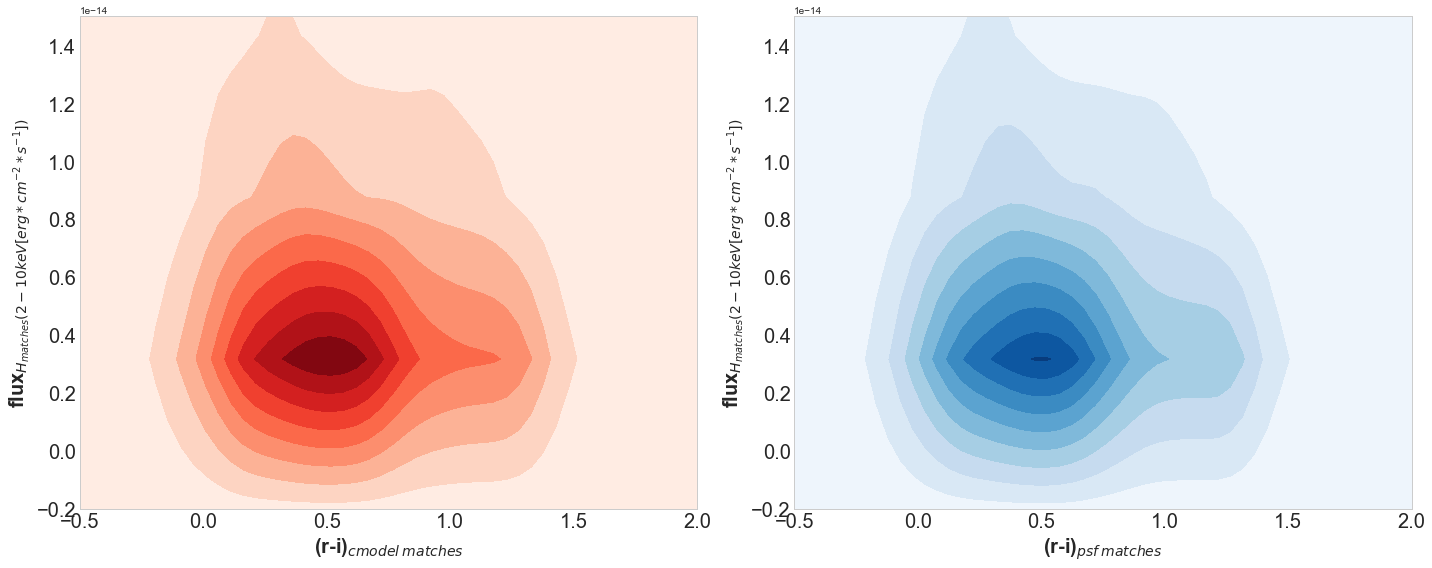

In [25]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,8))

min_matches_df = matches_df.loc[(matches_df.r_cmodel_magsigma < 0.2) & (matches_df.i_cmodel_magsigma < 0.2)]
sns.kdeplot(min_matches_df["r_cmodel_mag"] - min_matches_df["i_cmodel_mag"], min_matches_df["flux_H"],\
            cmap='Reds', ax = ax1, shade=True).set(xlim = (-0.5, 2), ylim = (-2e-15, 1.5e-14))

min_matches_df = matches_df.loc[(matches_df.r_psfflux_magsigma < 0.2) & (matches_df.i_psfflux_magsigma < 0.2)]
sns.kdeplot((min_matches_df["r_psfflux_mag"] - min_matches_df["i_psfflux_mag"]),min_matches_df["flux_H"],\
                cmap='Blues', ax = ax2, shade=True).set(xlim = (-0.5, 2), ylim = (-2e-15, 1.5e-14))

ax1.set_xlabel("(r-i)$_{cmodel\:matches}$", weight = "bold", size = 20)
ax1.set_ylabel("flux$_{H_{matches}(2 - 10keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax2.set_xlabel("(r-i)$_{psf\:matches}$", weight = "bold", size = 20)
ax2.set_ylabel("flux$_{H_{matches}(2 - 10keV [erg*cm^{-2}*s^{-1}])}$", weight = "bold", size = 20)

ax1.tick_params("both", labelsize = 20)
ax2.tick_params("both", labelsize = 20)

plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/ri_fluxH.png", transparent = True)


In [ ]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
hist = sns.distplot(no_counterparts.flux_F, color = "tomato", rug = True, bins = np.arange(0,1e-13,1e-15), \
                    kde = False, norm_hist = False, hist_kws={'edgecolor':'black'},ax = ax1)
hist.set_xlabel("flux_F${_{no\:counterparts}}$", fontsize=15, fontweight='bold')
hist.set_ylabel("Counts", fontsize=15, fontweight='bold')
hist.set_xlim([0,.15e-13])
# hist.set_yscale("log")
ax1.tick_params("both", labelsize = 15)

hist2 = sns.distplot(min_matches_df.flux_F, color = "tomato", rug = True, bins = np.arange(0,1e-13,1e-15), \
                    kde = False, norm_hist = False, hist_kws={'edgecolor':'black'},ax = ax2)
hist2.set_xlabel("flux_F${_{matches}}(0.5 - 10keV\:[erg*cm^{-2}*s^{-1}])$", fontsize=15, fontweight='bold')
hist2.set_ylabel("Counts", fontsize=15, fontweight='bold')
hist2.set_xlim([0,.15e-13])
ax2.tick_params("both", labelsize = 15)

hist3 = sns.distplot(Chandra_Data.flux_F, color = "magenta", rug = False,bins = np.arange(0,1e-13,0.1e-14),\
                     kde = False, norm_hist = False, hist_kws={'edgecolor':'black'},ax = ax3)
# hist2.set_yscale("log")
hist3.set_xlim([0,1.5e-14])
hist3.set_xlabel("flux_F${_{Chandra\:Data}}}$", fontsize=15, fontweight='bold')
hist3.set_ylabel("Counts", fontsize=15, fontweight='bold')
ax3.tick_params("both", labelsize = 15)
plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/Comparison/flux_F.png", transparent = True)

In [ ]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
hist = sns.distplot(no_counterparts.flux_S, color = "tomato", rug = True, bins = np.arange(0,1e-13,1e-15), \
                    kde = False, norm_hist = False, hist_kws={'edgecolor':'black'},ax = ax1)
hist.set_xlabel("flux_S${_{no\:counterparts}}$", fontsize=15, fontweight='bold')
hist.set_ylabel("Counts", fontsize=15, fontweight='bold')
hist.set_xlim([0,.5e-14])
ax1.tick_params("both", labelsize = 15)

hist2 = sns.distplot(matches_df.flux_S, color = "tomato", rug = True, bins = np.arange(0,1e-13,1e-15), \
                    kde = False, norm_hist = False, hist_kws={'edgecolor':'black'},ax = ax2)
hist2.set_xlabel("flux_S${_{matches}}(0.5 - 2keV\:[erg*cm^{-2}*s^{-1}])$", fontsize=15, fontweight='bold')
hist2.set_ylabel("Counts", fontsize=15, fontweight='bold')
hist2.set_xlim([0,.5e-14])
ax2.tick_params("both", labelsize = 15)

hist3 = sns.distplot(Chandra_Data.flux_S, color = "magenta", rug = False,bins = np.arange(0,1e-13,0.1e-15),\
                     kde = False, norm_hist = False, hist_kws={'edgecolor':'black'},ax = ax3)
# hist2.set_yscale("log")
hist3.set_xlim([0,.5e-14])
hist3.set_xlabel("flux_S${_{Chandra\:Data}}}$", fontsize=15, fontweight='bold')
hist3.set_ylabel("Counts", fontsize=15, fontweight='bold')
ax3.tick_params("both", labelsize = 15)
plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/Comparison/flux_S.png", transparent = True)

In [ ]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
hist = sns.distplot(no_counterparts.flux_H, color = "tomato", rug = True, bins = np.arange(0,1e-13,1e-15), \
                    kde = False, norm_hist = False, hist_kws={'edgecolor':'black'},ax = ax1)
hist.set_xlabel("flux_H${_{no\:counterparts}}$", fontsize=15, fontweight='bold')
hist.set_ylabel("Counts", fontsize=15, fontweight='bold')
hist.set_xlim([0,1e-14])
ax1.tick_params("both", labelsize = 15)

hist2 = sns.distplot(matches_df.flux_H, color = "tomato", rug = True, bins = np.arange(0,1e-13,1e-15), \
                    kde = False, norm_hist = False, hist_kws={'edgecolor':'black'},ax = ax2)
hist2.set_xlabel("flux_H${_{matches}}(2 - 10keV\:[erg*cm^{-2}*s^{-1}])$", fontsize=15, fontweight='bold')
hist2.set_ylabel("Counts", fontsize=15, fontweight='bold')
hist2.set_xlim([0,1e-14])
ax2.tick_params("both", labelsize = 15)

hist3 = sns.distplot(Chandra_Data.flux_H, color = "magenta", rug = False,bins = np.arange(0,1e-13,0.1e-15),\
                     kde = False, norm_hist = False, hist_kws={'edgecolor':'black'},ax = ax3)
# hist2.set_yscale("log")
hist3.set_xlim([0,1e-14])
hist3.set_xlabel("flux_H${_{Chandra\:Data}}}$", fontsize=15, fontweight='bold')
hist3.set_ylabel("Counts", fontsize=15, fontweight='bold')
ax3.tick_params("both", labelsize = 15)
plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/Comparison/flux_H.png", transparent = True)

In [ ]:
plt.style.use("seaborn-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))


hist2 = sns.distplot(matches_df.HR[matches_df.HR > -60], color = "blue", bins = np.arange(-1,1,.05), \
                     rug = False, hist=True, kde=True, hist_kws={'edgecolor':'black'}, ax = ax1)
hist2.set_xlabel("HR$_{matched}$", fontsize=15, fontweight='bold')
hist2.set_ylabel("Density", fontsize=15, fontweight='bold')


hist = sns.distplot(min_nocounterparts_df.HR[min_nocounterparts_df.HR > -20], color = "tomato", bins = np.arange(-1,1,.05), \
                    rug = True, hist=True, kde=True,hist_kws={'edgecolor':'black'}, ax = ax2)
hist.set_xlabel("HR$_{not\:matched}$", fontsize=15, fontweight='bold')
hist.set_ylabel("Density", fontsize=15, fontweight='bold')
ax1.tick_params("both", labelsize = 20)


hist3 = sns.distplot(Chandra_Data.HR[Chandra_Data.HR > -60], color = "magenta", bins = np.arange(-1,1,.05), \
                     rug = False, hist=True, kde=True, hist_kws={'edgecolor':'black'}, ax = ax3)
hist3.set_xlabel("HR$_{Chandra\:Data}$", fontsize=15, fontweight='bold')
hist3.set_ylabel("Density", fontsize=15, fontweight='bold')

ax1.tick_params("both", labelsize = 20)
ax2.tick_params("both", labelsize = 20)
ax3.tick_params("both", labelsize = 20)

plt.tight_layout()
plt.savefig("/Users/linaflorez/Desktop/ObsCos/COSMOS_research/Plots/Comparison/HR.png", transparent = True)

